In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

from keras.models import Sequential
from keras import layers
from keras import regularizers
import tensorflow as tf

import time
import datetime

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 200
# plt.style.use('dark_background')

2023-11-20 13:37:21.732512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 13:37:21.851976: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 13:37:22.504003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-11-20 13:37:22.504074: W tensorflow/compiler/xla/stream

In [2]:
# Pull other datasets and evaluate model performance against them too!

paths = [
    'problems MoonBoard 2016 .json',
    'problems MoonBoard Masters 2017 40.json',
    'problems MoonBoard Masters 2019 40.json',
]

In [3]:
grades = {
    '':   -1,
    '6A+': 0,
    '6B':  1,
    '6B+': 2,
    '6C':  3,
    '6C+': 4,
    '7A':  5,
    '7A+': 6,
    '7B':  7,
    '7B+': 8,
    '7C':  9,
    '7C+': 10,
    '8A':  11,
    '8A+': 12,
    '8B':  13,
    '8B+': 14,
}

In [4]:
def moves_to_features( moves ):
    print( moves, end = '\r' )
    features = np.zeros( ( 18, 11 ) )
    
    for move in moves:
        move = move.upper()
        features[int( move[1:] ) - 1, ord( str( move[0] ).upper() ) - 65 ] = 1
    return np.flip( features, axis = 0 )

In [5]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

def evaluate( train_predictions, predictions, y_train, y_test, plot_predictions = False ):
    metrics = {
        'train_mae': mae( y_train, train_predictions ),
        'train_rmse': mse( y_train, train_predictions ) ** ( 1 / 2 ),
        'test_mae': mae( y_test, predictions ),
        'test_rmse': mse( y_test, predictions ) ** ( 1 / 2 ),
    }
    
    predictions = predictions.flatten()
    
    if plot_predictions == True:
            # Residual plot
            plot = sns.jointplot(
                predictions,
                y_test,
                kind = 'hist',
            )
            plot.ax_joint.set_xticks( range( len( grades ) ), grades )
            plot.ax_joint.set_yticks( range( len( grades ) ), grades )
            plot.ax_joint.plot([0,13], [0, 13], 'b-', linewidth = 2, alpha = 0.4 )
            plot.ax_joint.set_xlabel( 'Predicted Grade' )
            plot.ax_joint.set_ylabel( 'True Grade' )

            plt.show()
            
            # Plot
    
    return metrics

In [6]:
def getDataset( path ):
    df = pd.read_json( path )
    l = []
    for i, row in df.iterrows():
        l.append( row['data'] )
    df = pd.DataFrame( l )
    
    # Cleaning:
    df = df[df['repeats'] >= 5 ]
    
    grades = {
        '':   -1,
        '6A+': 0,
        '6B':  1,
        '6B+': 2,
        '6C':  3,
        '6C+': 4,
        '7A':  5,
        '7A+': 6,
        '7B':  7,
        '7B+': 8,
        '7C':  9,
        '7C+': 10,
        '8A':  11,
        '8A+': 12,
        '8B':  13,
        '8B+': 14,
    }
    
    df.fillna( '', inplace = True )
    
    df['grade_index'] = df.apply(
        lambda x: grades[x['grade']], axis = 1
    )
    
    grade, is_benchmark, moves, repeats = [], [], [], []
    for i, row in df.iterrows():
        # row = row['data']
        grade.append(row['grade'])
        is_benchmark.append(row['isBenchmark'])
        moves.append( [ move['description'] for move in row['moves'] ] )
        repeats.append( row['repeats'] )
    
    processed_df = pd.DataFrame( {
        'grade': grade,
        'is_benchmark': is_benchmark,
        'moves': moves,
        'repeats': repeats
    } )
    
    processed_df['features'] = processed_df.apply( 
        lambda x: moves_to_features( x['moves'] ), axis = 1
    )
    
    processed_df['features_flat'] = processed_df.apply( 
        lambda x: x['features'].flatten(), axis = 1
    )
    
    processed_df['grade_index'] = processed_df.apply(
        lambda x: grades[x['grade']], axis = 1
    )
    
    processed_df['n_holds'] = processed_df.apply(
        lambda x: len( x['moves'] ), axis = 1
    )
    
    X_train = np.array( processed_df[processed_df['is_benchmark'] == False]['features'].tolist() ).reshape( -1, 18 * 11 )
    X_test = np.array( processed_df[processed_df['is_benchmark'] == True]['features'].tolist() ).reshape( -1, 18 * 11 )

    y_train = np.array( processed_df[processed_df['is_benchmark'] == False]['grade_index'].tolist() )
    y_test = np.array( processed_df[processed_df['is_benchmark'] == True]['grade_index'].tolist() )
    
    return X_train, y_train, X_test, y_test

In [7]:
def getTest( path ):
    df = pd.read_json( path )
    l = []
    for i, row in df.iterrows():
        l.append( row['data'] )
    df = pd.DataFrame( l )
    
    # Cleaning:
    df = df[df['repeats'] >= 5 ]
    
    grades = {
        '':   -1,
        '6A+': 0,
        '6B':  1,
        '6B+': 2,
        '6C':  3,
        '6C+': 4,
        '7A':  5,
        '7A+': 6,
        '7B':  7,
        '7B+': 8,
        '7C':  9,
        '7C+': 10,
        '8A':  11,
        '8A+': 12,
        '8B':  13,
        '8B+': 14,
    }
    
    df.fillna( '', inplace = True )
    
    df['grade_index'] = df.apply(
        lambda x: grades[x['grade']], axis = 1
    )
    
    grade, is_benchmark, moves, repeats = [], [], [], []
    for i, row in df.iterrows():
        # row = row['data']
        grade.append(row['grade'])
        is_benchmark.append(row['isBenchmark'])
        moves.append( [ move['description'] for move in row['moves'] ] )
        repeats.append( row['repeats'] )
    
    processed_df = pd.DataFrame( {
        'grade': grade,
        'is_benchmark': is_benchmark,
        'moves': moves,
        'repeats': repeats
    } )
    
    processed_df['features'] = processed_df.apply( 
        lambda x: moves_to_features( x['moves'] ), axis = 1
    )
    
    processed_df['features_flat'] = processed_df.apply( 
        lambda x: x['features'].flatten(), axis = 1
    )
    
    processed_df['grade_index'] = processed_df.apply(
        lambda x: grades[x['grade']], axis = 1
    )
    
    processed_df['n_holds'] = processed_df.apply(
        lambda x: len( x['moves'] ), axis = 1
    )
    
    # X_train = np.array( processed_df[processed_df['is_benchmark'] == False]['features'].tolist() ).reshape( -1, 18 * 11 )
    X_test = np.array( processed_df[processed_df['is_benchmark'] == True]['features'].tolist() ).reshape( -1, 18 * 11 )

    # y_train = np.array( processed_df[processed_df['is_benchmark'] == False]['grade_index'].tolist() )
    y_test = np.array( processed_df[processed_df['is_benchmark'] == True]['grade_index'].tolist() )
    
    return X_test, y_test

In [8]:
def getModels():
    dnn = Sequential( [
        layers.Input( shape = ( 18 * 11 ) ),
        layers.Dense( 64, activation = 'relu' ),
        layers.Dense( 32, activation = 'relu' ),
        layers.Dense( 16, activation = 'relu' ),
        layers.Dense( 1, activation = 'linear' ),
    ] )


    cnn = Sequential( [
        layers.Input( shape = ( 18 * 11 ) ),
        layers.Reshape( target_shape = ( 18, 11, 1 ) ),
        layers.Conv2D( 32, 3, activation = 'relu' ),
        layers.BatchNormalization(),
        layers.Conv2D( 32, 3, activation = 'relu' ),
        layers.BatchNormalization(),
        layers.Conv2D( 64, 3, activation = 'relu' ),
        layers.BatchNormalization(),
        layers.Conv2D( 64, 3, activation = 'relu' ),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense( 32, activation = 'relu' ),
        layers.Dense( 1, activation = 'linear' ),
    ] )

    lstm = Sequential( [
        layers.Input( shape = ( 18 * 11 ) ),
        layers.Reshape( target_shape = ( 18, 11 ) ),
        layers.LSTM( 128 ),
        layers.Dense( 32, activation = 'relu' ),
        layers.Dense( 1, activation = 'linear' ),
    ] )

    nn = Sequential( [
        layers.Input( shape = ( 18 * 11 ) ),
        layers.Reshape( target_shape = ( 18, 11, 1 ) ),
        layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.Dropout( 0.1 ),
        layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.Dropout( 0.1 ),
        layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.Dropout( 0.1 ),
        layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.Dropout( 0.1 ),
        layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.Dropout( 0.1 ),
        layers.Dense( 128, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.Dropout( 0.1 ),
        layers.Conv2D( 32, 3, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.BatchNormalization(),
        layers.Dropout( 0.1 ),
        layers.Conv2D( 32, 3, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.BatchNormalization(),
        layers.Dropout( 0.1 ),
        layers.Conv2D( 64, 3, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.BatchNormalization(),
        layers.Dropout( 0.1 ),
        layers.Conv2D( 64, 3, activation = 'relu', kernel_regularizer = regularizers.l2( 0.001 ) ),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense( 32, activation = 'relu' ),
        layers.Dense( 1, activation = 'linear' ),
        layers.Dense( 1, activation = 'linear' ),
    ] )

    models = [ dnn, cnn, lstm, nn ]

    for model in models:
        model.compile(
            loss = 'mean_squared_error',
            optimizer = 'adam',
            metrics = [
                tf.keras.metrics.RootMeanSquaredError( name = 'RMSE' ),
                tf.keras.metrics.MeanAbsoluteError( name = 'MAE' ),
            ]
        )
    
    return models

In [9]:
# Pull other datasets and evaluate model performance against them too!

paths = [
    'problems MoonBoard 2016 .json',
    'problems MoonBoard Masters 2017 40.json',
    'problems MoonBoard Masters 2019 40.json',
]

In [10]:
combinations = [
    [ 0, 1, 2 ],
    [ 1, 2, 0 ],
    [ 2, 0, 1 ],
]

[0, 1, 2]


2023-11-20 13:37:49.127675: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-11-20 13:37:49.127719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cma-dev
2023-11-20 13:37:49.127727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cma-dev
2023-11-20 13:37:49.127868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.147.5
2023-11-20 13:37:49.127891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.106.0
2023-11-20 13:37:49.127899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 460.106.0 does not match DSO version 525.147.5 -- cannot find working devices in this configuration
2023-11-20 13:37

DNN
Epoch 1/200
6472/6472 [==============================] - 8s 1ms/step - loss: 2.1498 - RMSE: 1.4662 - MAE: 1.0185 - val_loss: 2.0315 - val_RMSE: 1.4253 - val_MAE: 1.1030
Epoch 2/200
6472/6472 [==============================] - 7s 1ms/step - loss: 1.5289 - RMSE: 1.2365 - MAE: 0.8572 - val_loss: 1.9687 - val_RMSE: 1.4031 - val_MAE: 1.0717
Epoch 3/200
6472/6472 [==============================] - 7s 1ms/step - loss: 1.3752 - RMSE: 1.1727 - MAE: 0.8129 - val_loss: 1.8381 - val_RMSE: 1.3558 - val_MAE: 1.0409
Epoch 4/200
6472/6472 [==============================] - 7s 1ms/step - loss: 1.2742 - RMSE: 1.1288 - MAE: 0.7823 - val_loss: 1.6573 - val_RMSE: 1.2874 - val_MAE: 0.9971
Epoch 5/200
6472/6472 [==============================] - 7s 1ms/step - loss: 1.1991 - RMSE: 1.0950 - MAE: 0.7577 - val_loss: 1.6916 - val_RMSE: 1.3006 - val_MAE: 1.0014
Epoch 6/200
6472/6472 [==============================] - 7s 1ms/step - loss: 1.1378 - RMSE: 1.0667 - MAE: 0.7404 - val_loss: 1.7191 - val_RMSE: 1.3111 

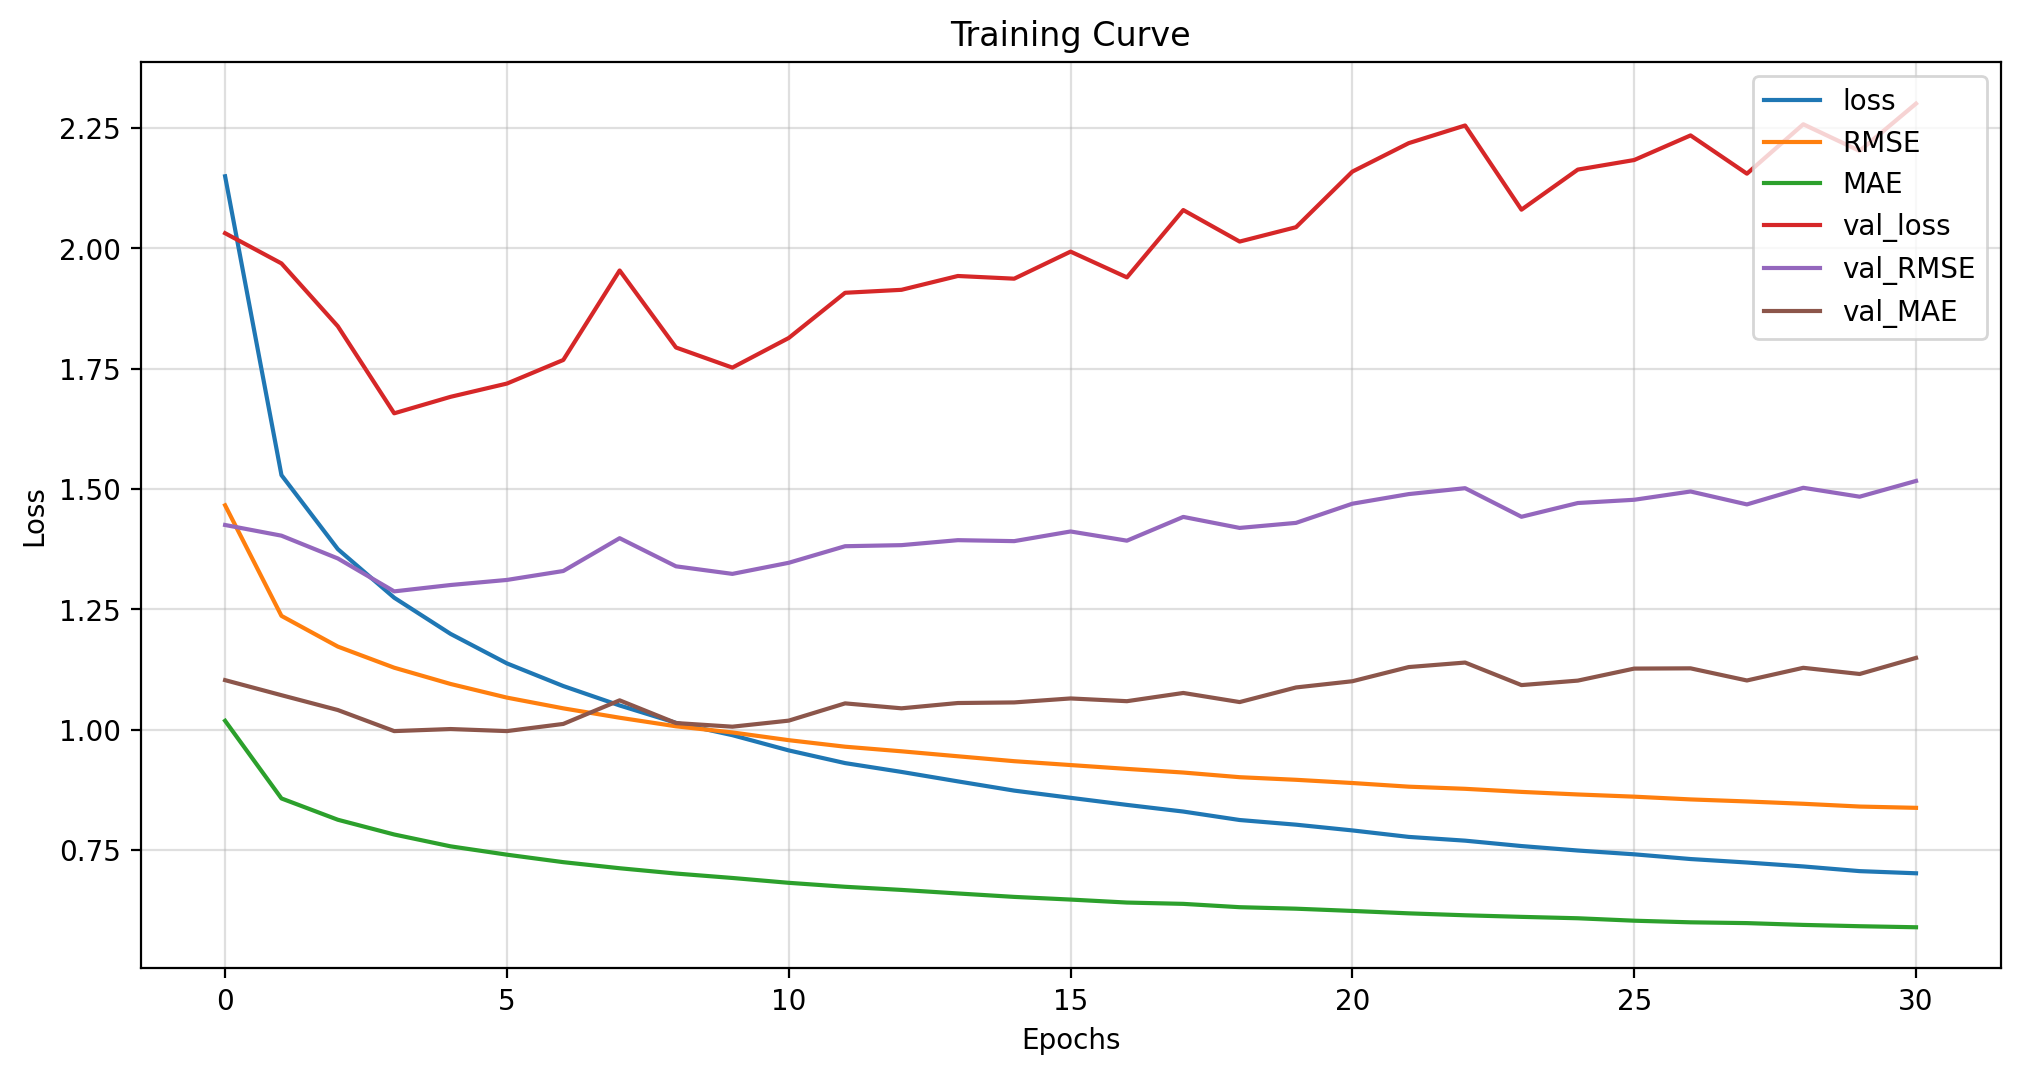

Time to Fit: 228.5984628200531
12/12 [==============================] - 0s 835us/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


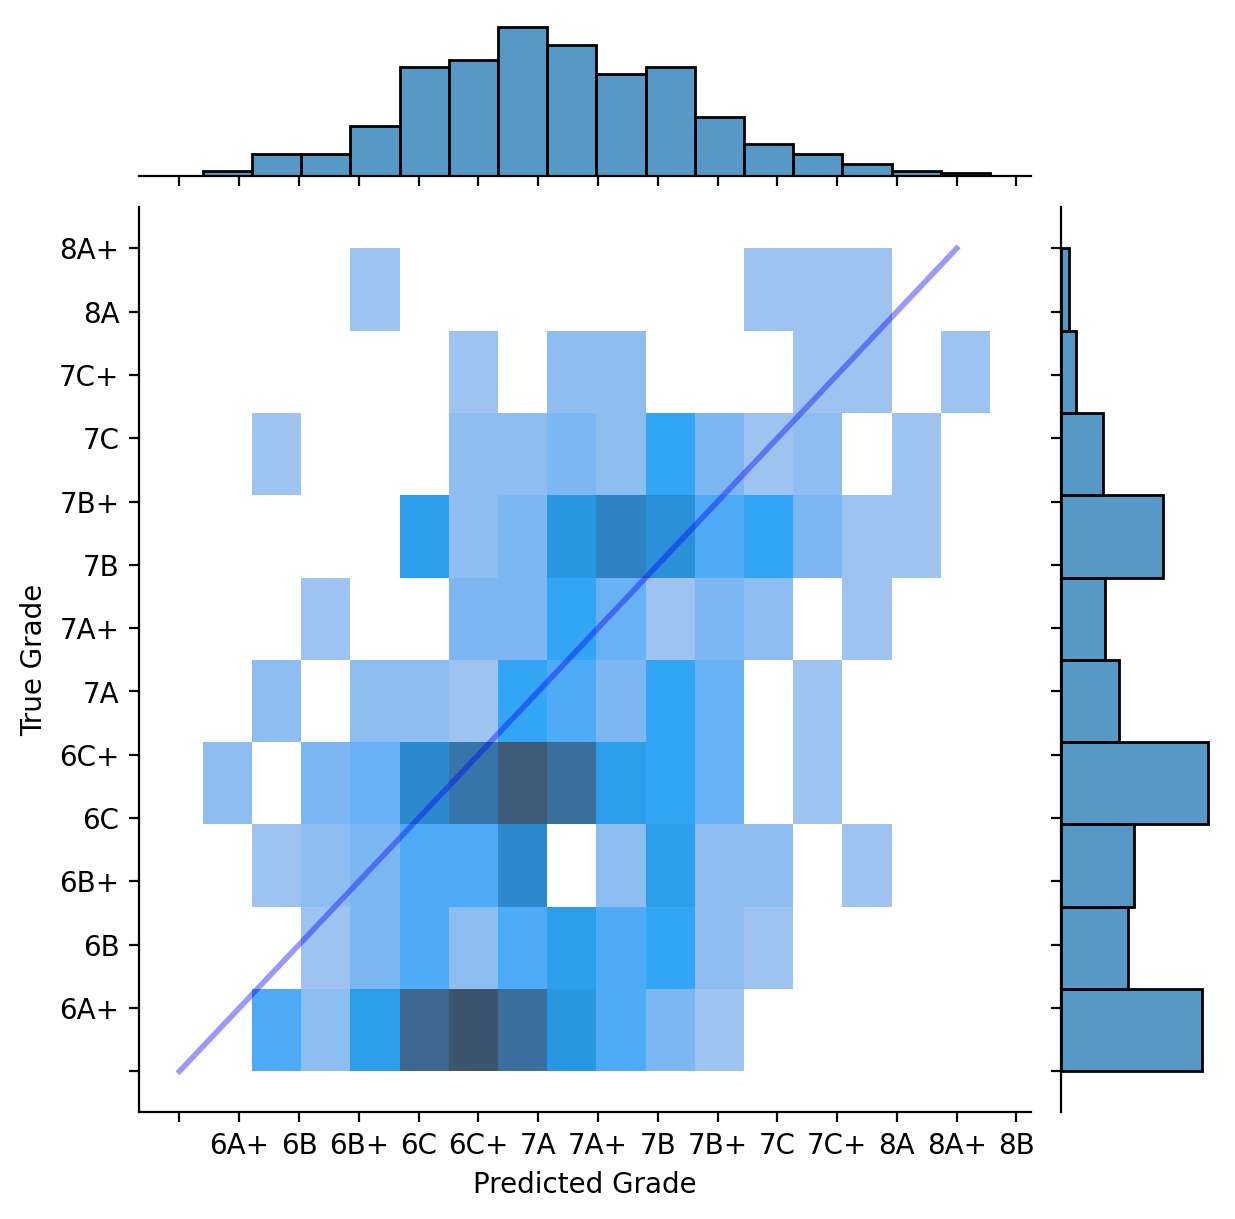

{'train_mae': 3.4383952208215796, 'train_rmse': 4.001046879718924, 'test_mae': 2.782519350397369, 'test_rmse': 3.408770920798563}

18/18 [==============================] - 0s 756us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard 2016 .json', 't2': 'problems MoonBoard Masters 2017 40.json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.9869194606028565, 'test_rmse': 1.2856372803894982}

18/18 [==============================] - 0s 3ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard 2016 .json', 't2': 'problems MoonBoard Masters 2017 40.json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 5.560799556340672, 'test_rmse': 6.111731449256012}

18/18 [

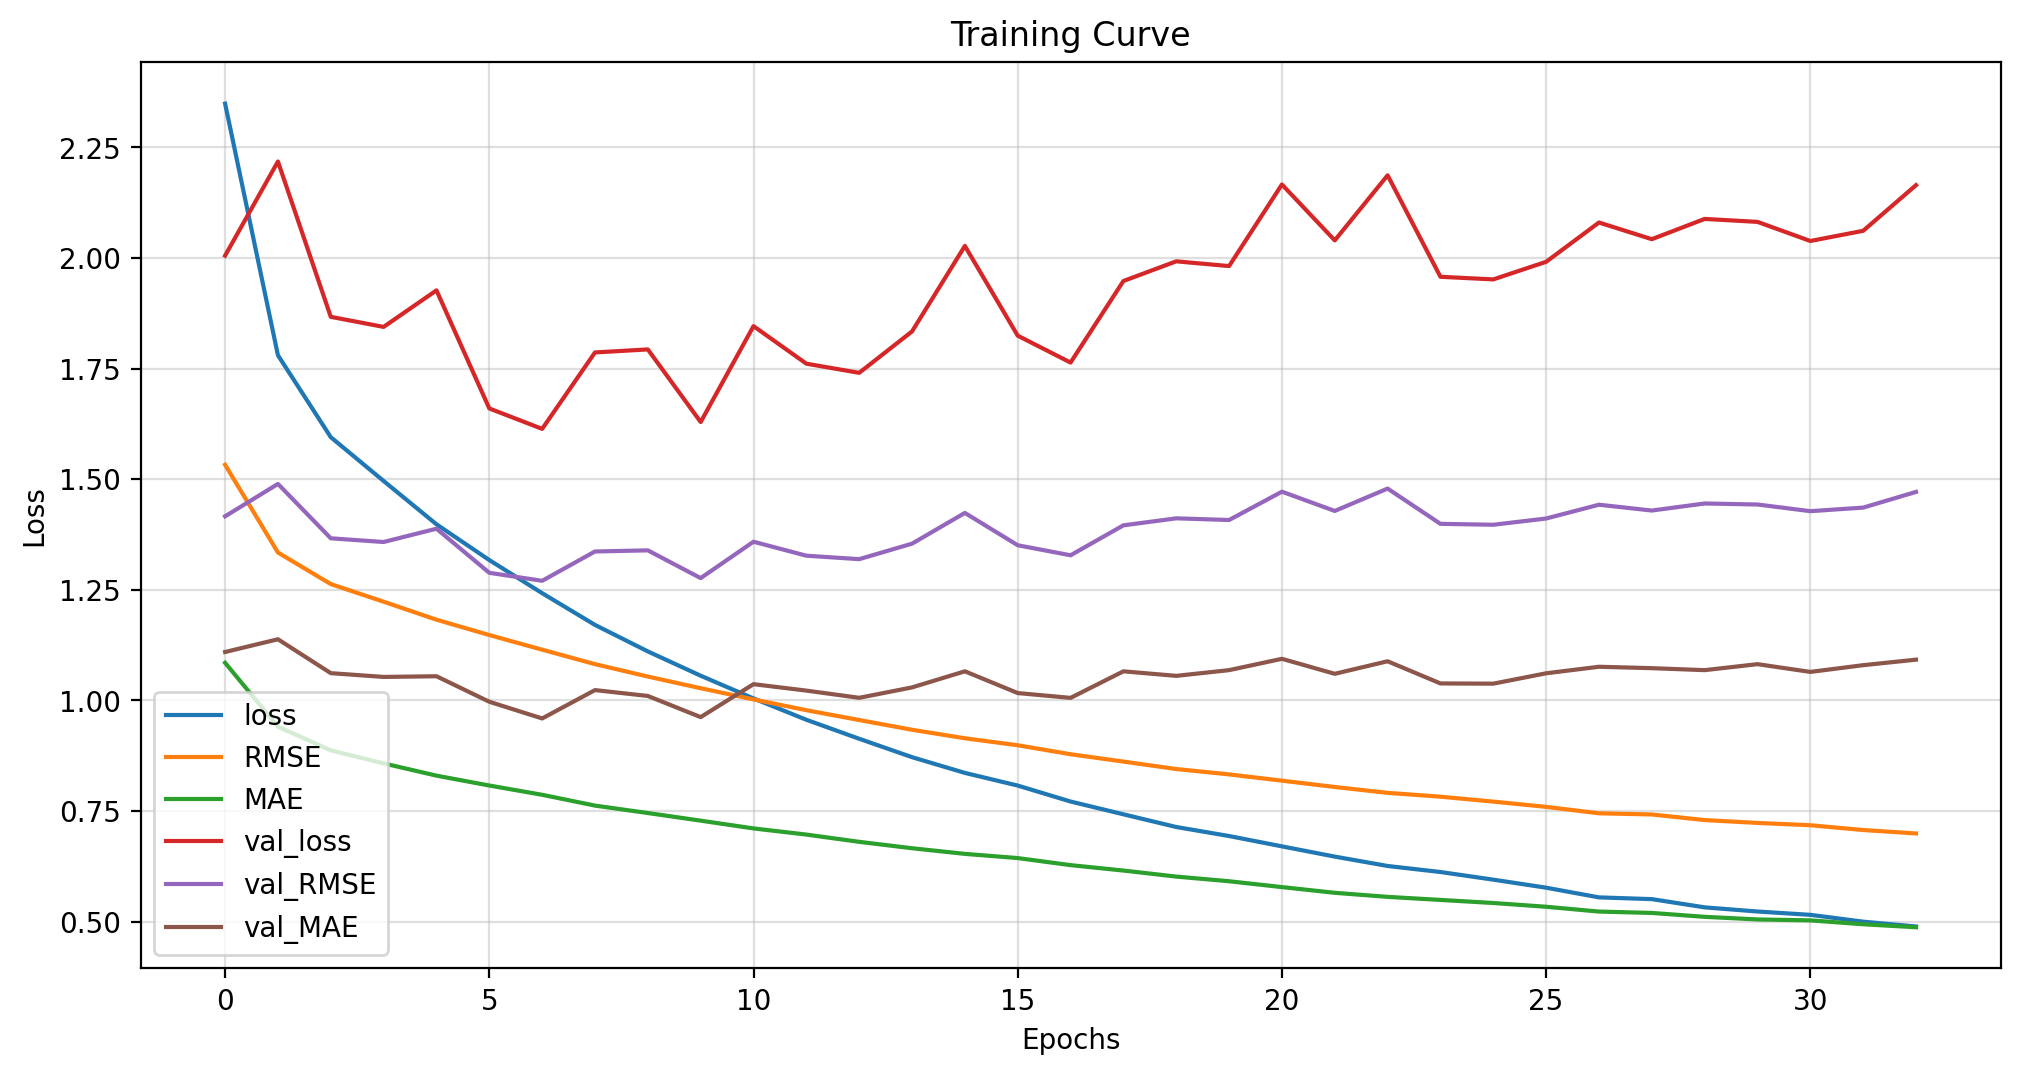

Time to Fit: 893.0648427009583
12/12 [==============================] - 0s 2ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


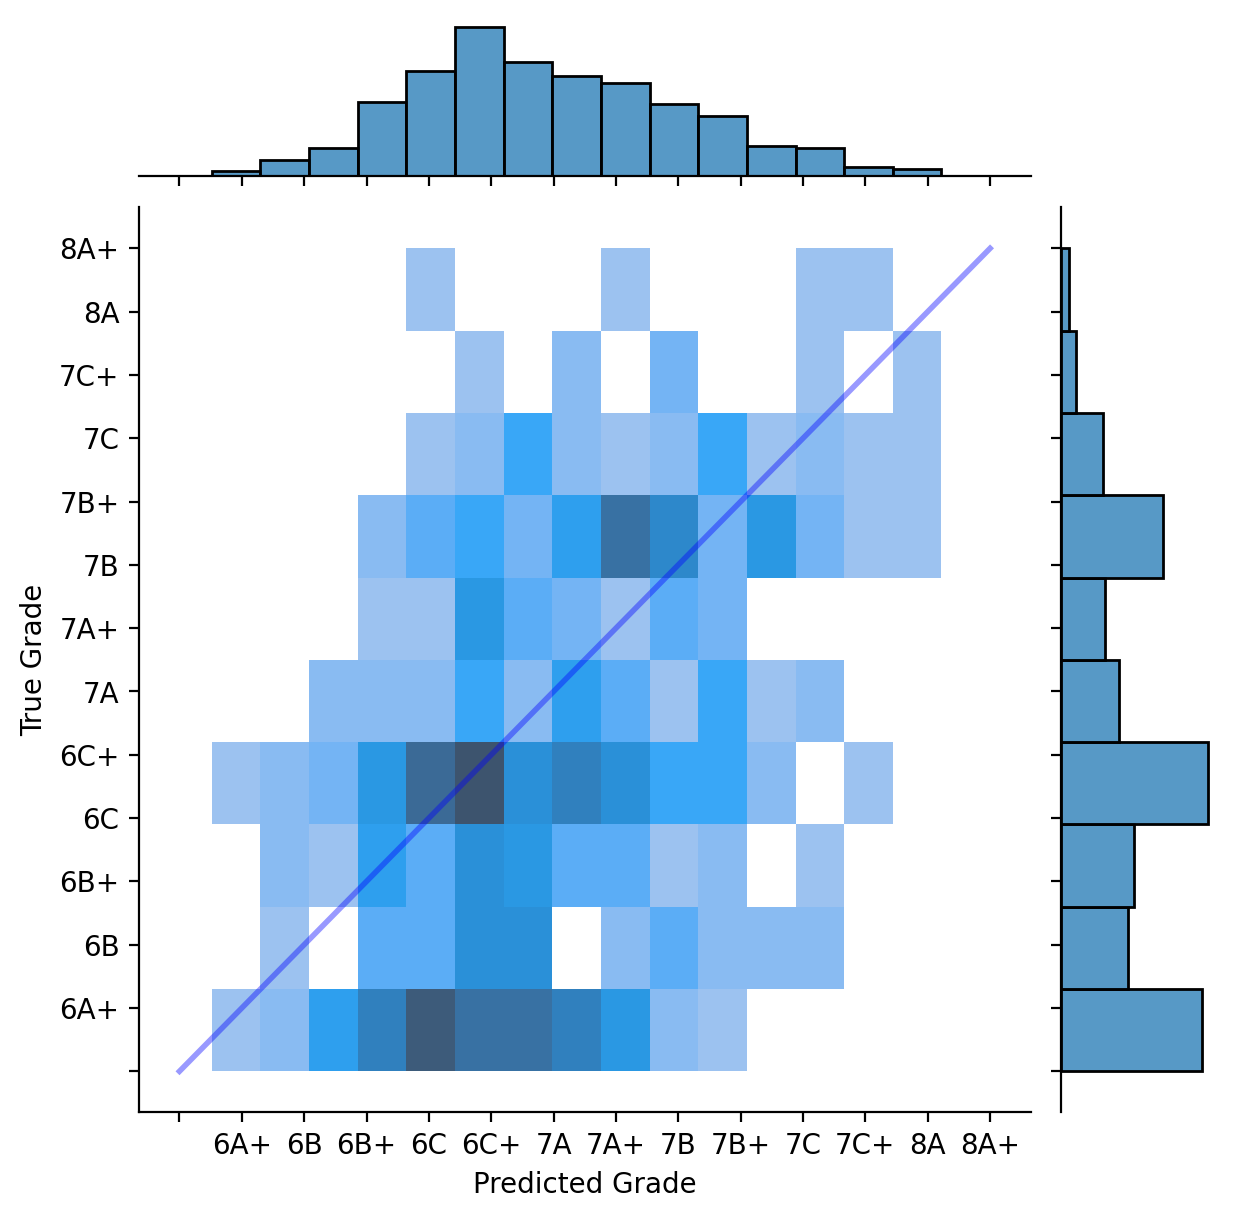

{'train_mae': 3.20482998601062, 'train_rmse': 3.7333037921951826, 'test_mae': 2.6716300230424648, 'test_rmse': 3.2643082040880924}

18/18 [==============================] - 0s 797us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard 2016 .json', 't2': 'problems MoonBoard Masters 2017 40.json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.9869194606028565, 'test_rmse': 1.2856372803894982}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard 2016 .json', 't2': 'problems MoonBoard Masters 2017 40.json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 1.0162408260030484, 'test_rmse': 1.3382954647803738}

18/1

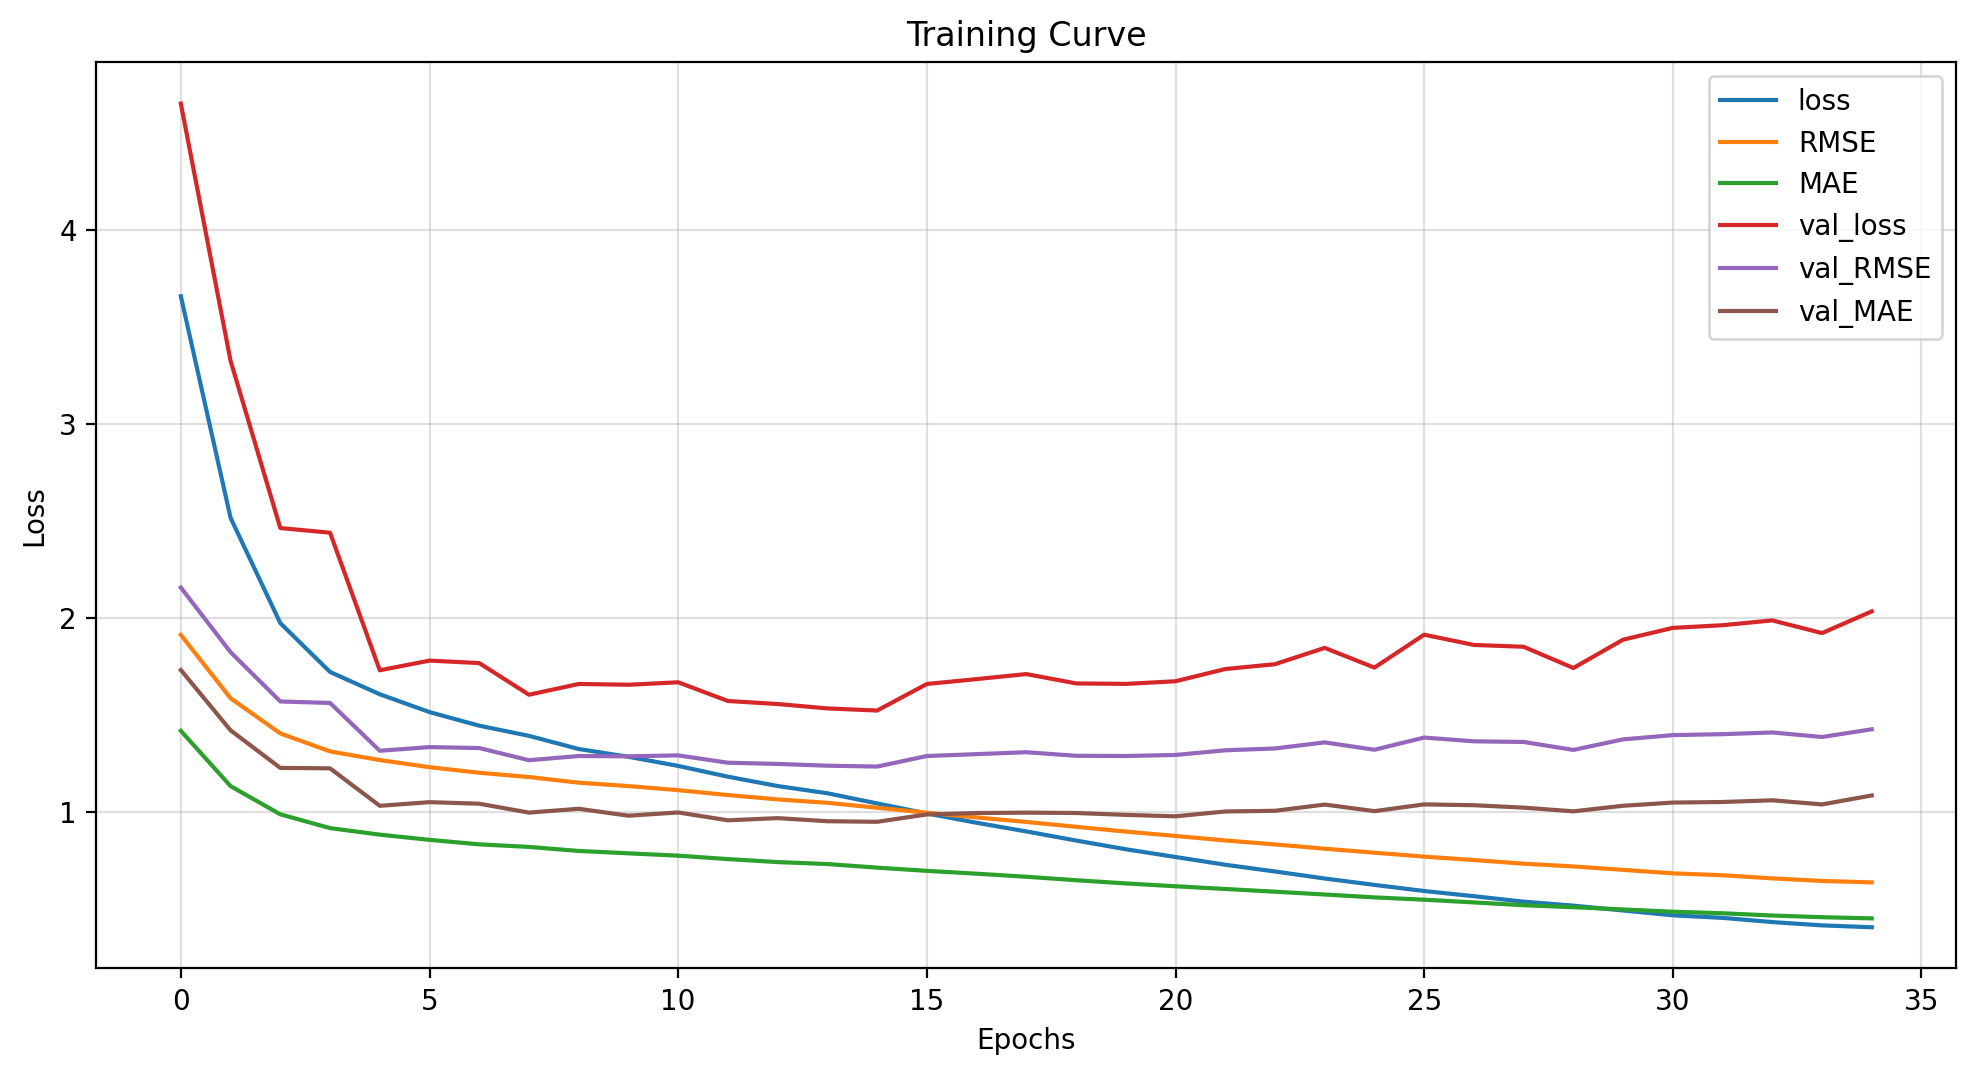

Time to Fit: 1483.9393503665924
12/12 [==============================] - 0s 4ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


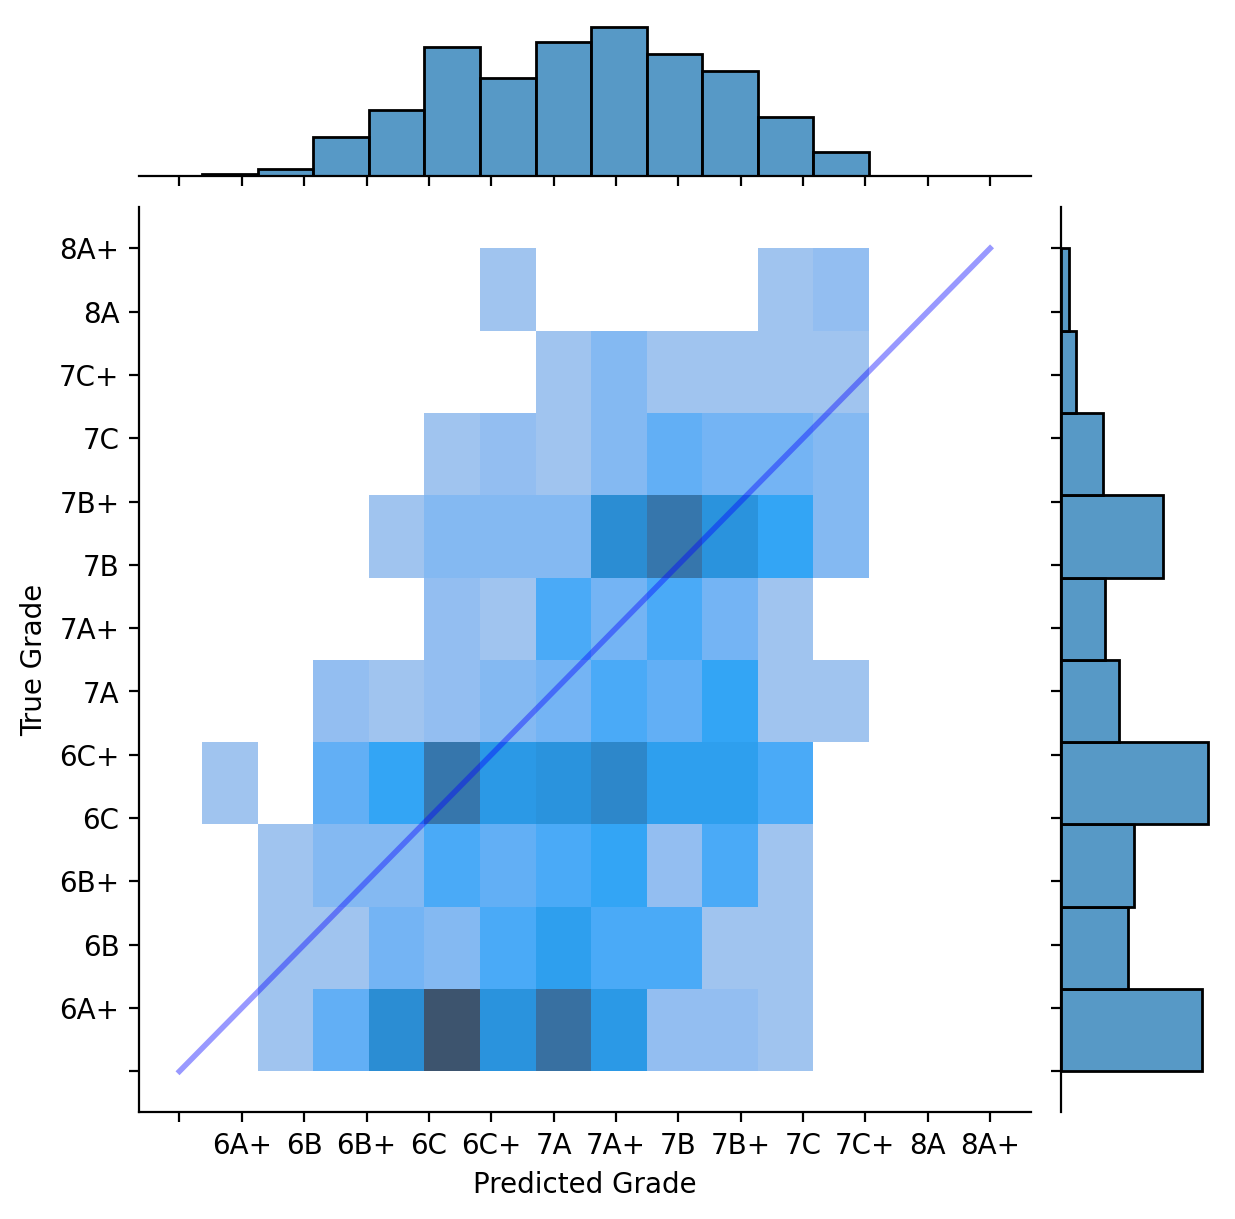

{'train_mae': 3.3136374974593497, 'train_rmse': 3.8146496434394366, 'test_mae': 2.7450104150386143, 'test_rmse': 3.348363974061438}

18/18 [==============================] - 0s 818us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard 2016 .json', 't2': 'problems MoonBoard Masters 2017 40.json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.9869194606028565, 'test_rmse': 1.2856372803894982}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard 2016 .json', 't2': 'problems MoonBoard Masters 2017 40.json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 1.0162408260030484, 'test_rmse': 1.3382954647803738}

18/

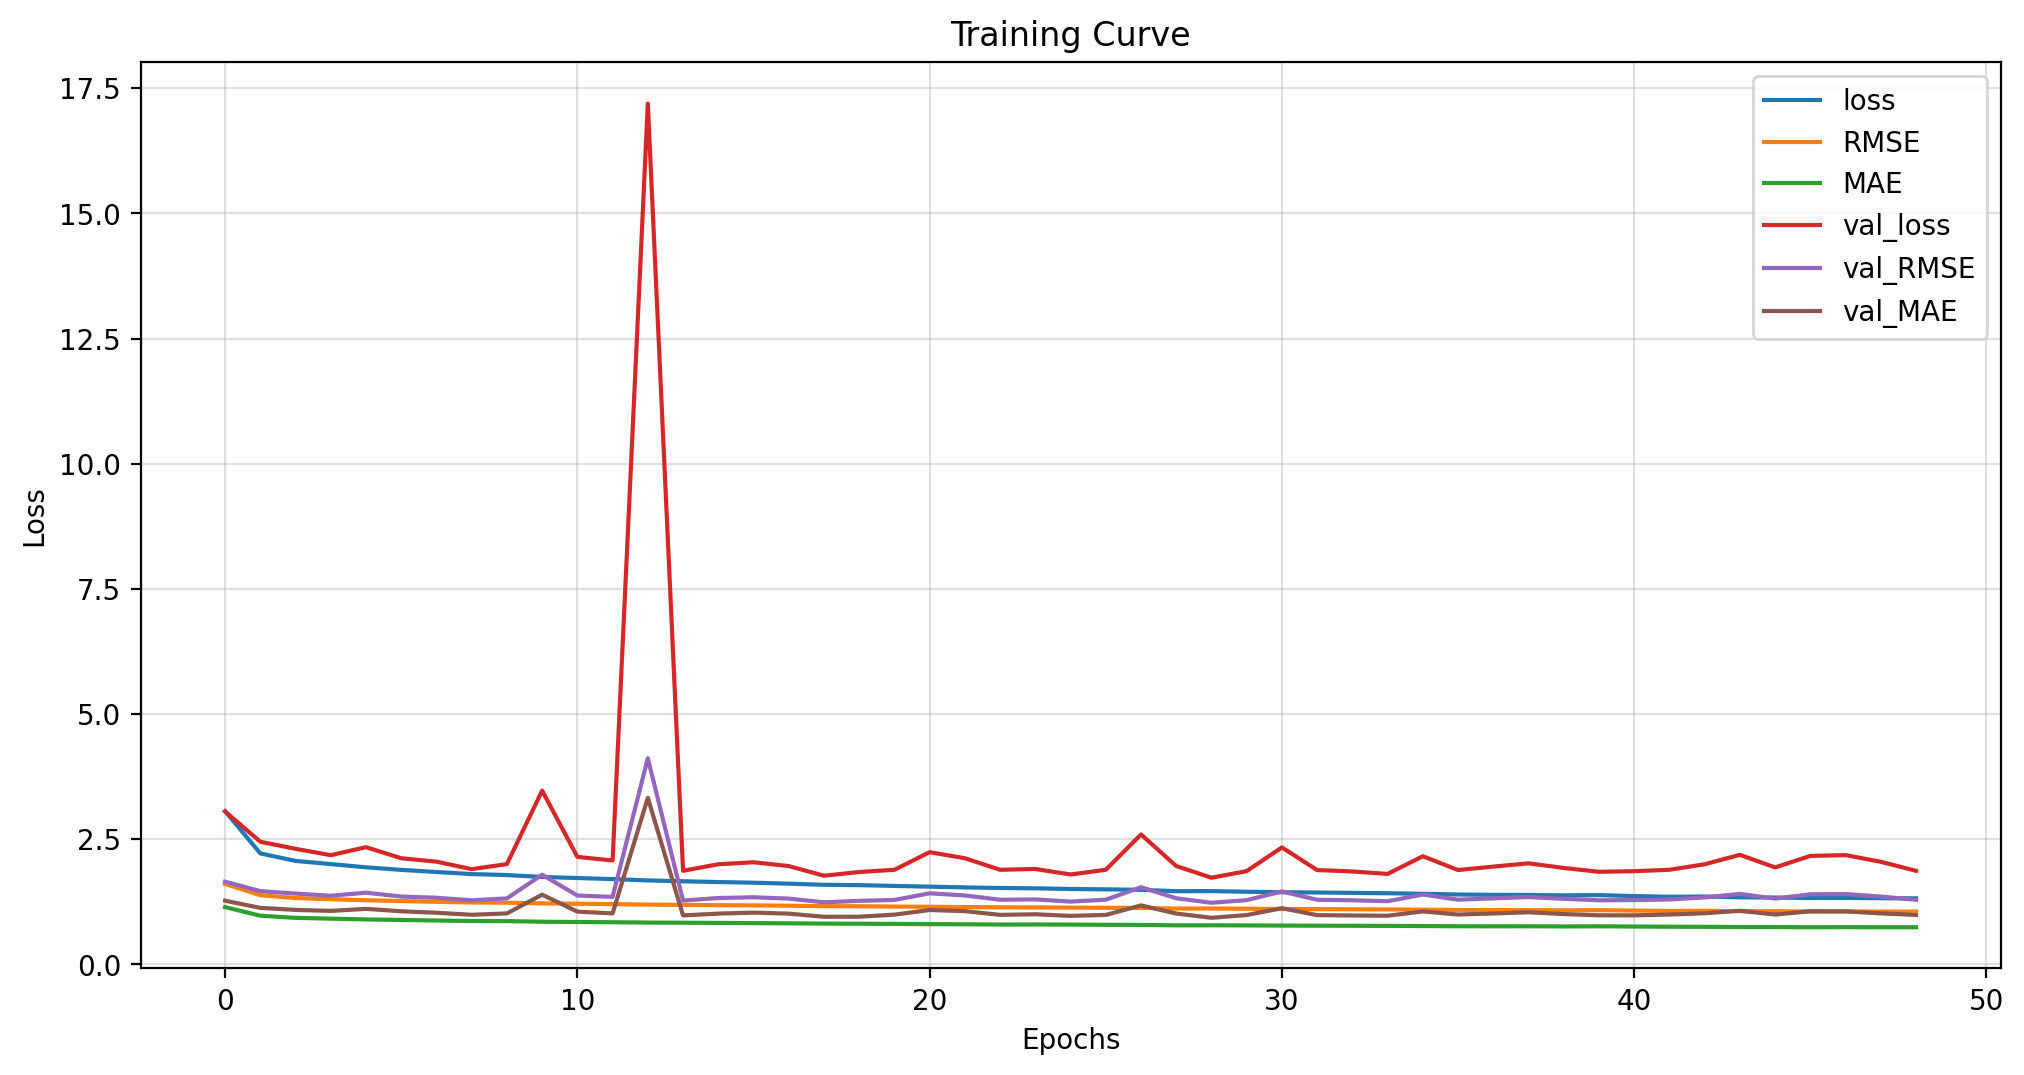

Time to Fit: 4801.653856039047
12/12 [==============================] - 0s 7ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


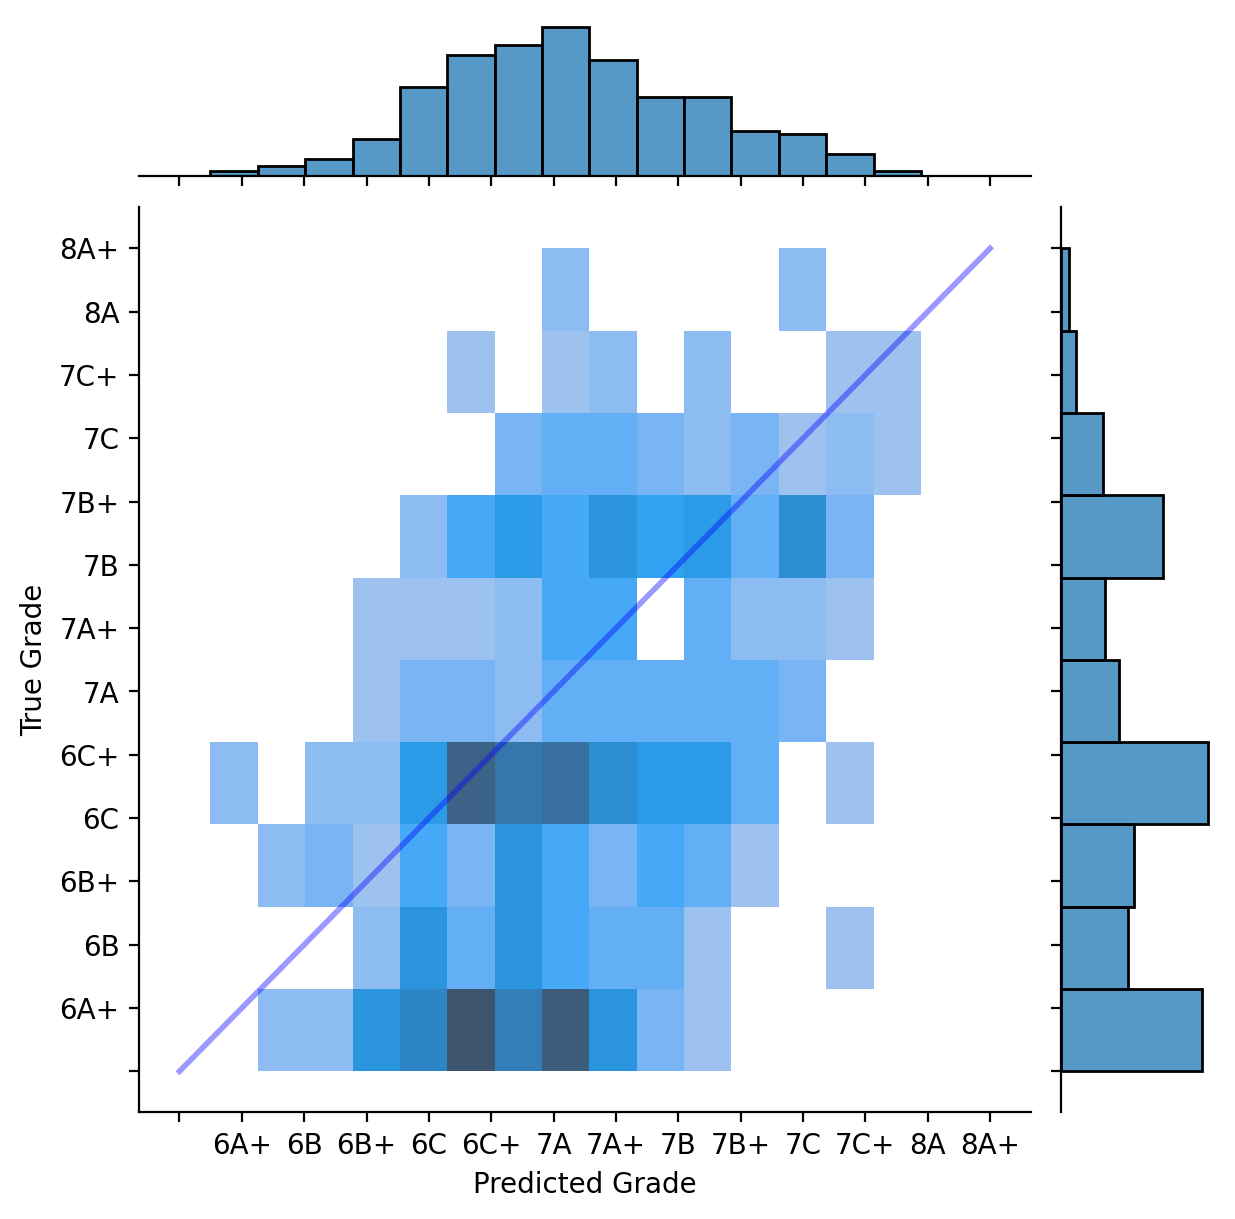

{'train_mae': 3.3154998572632737, 'train_rmse': 3.815432370219799, 'test_mae': 2.7621839119622353, 'test_rmse': 3.3063225886656835}

18/18 [==============================] - 0s 774us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard 2016 .json', 't2': 'problems MoonBoard Masters 2017 40.json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.9869194606028565, 'test_rmse': 1.2856372803894982}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard 2016 .json', 't2': 'problems MoonBoard Masters 2017 40.json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 1.0162408260030484, 'test_rmse': 1.3382954647803738}

18/

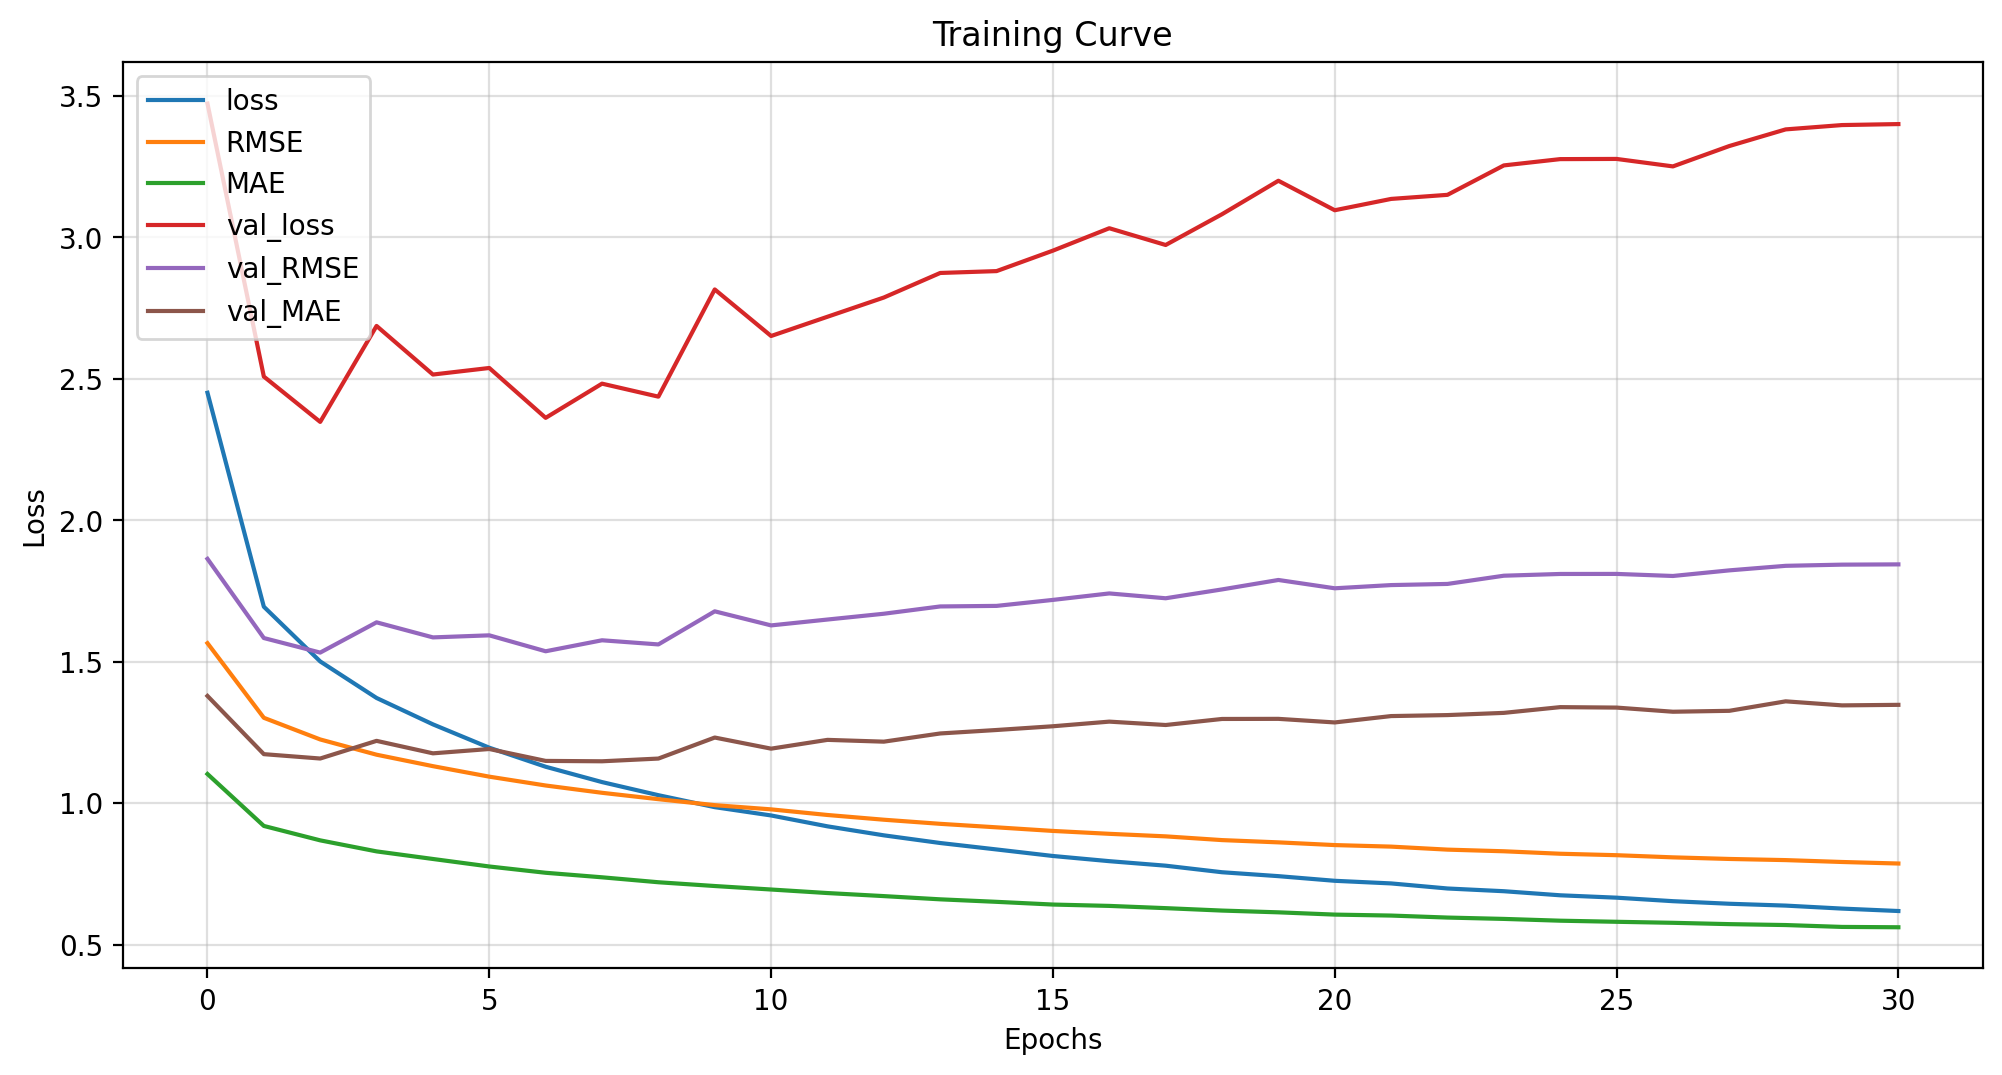

Time to Fit: 159.94590210914612
18/18 [==============================] - 0s 772us/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


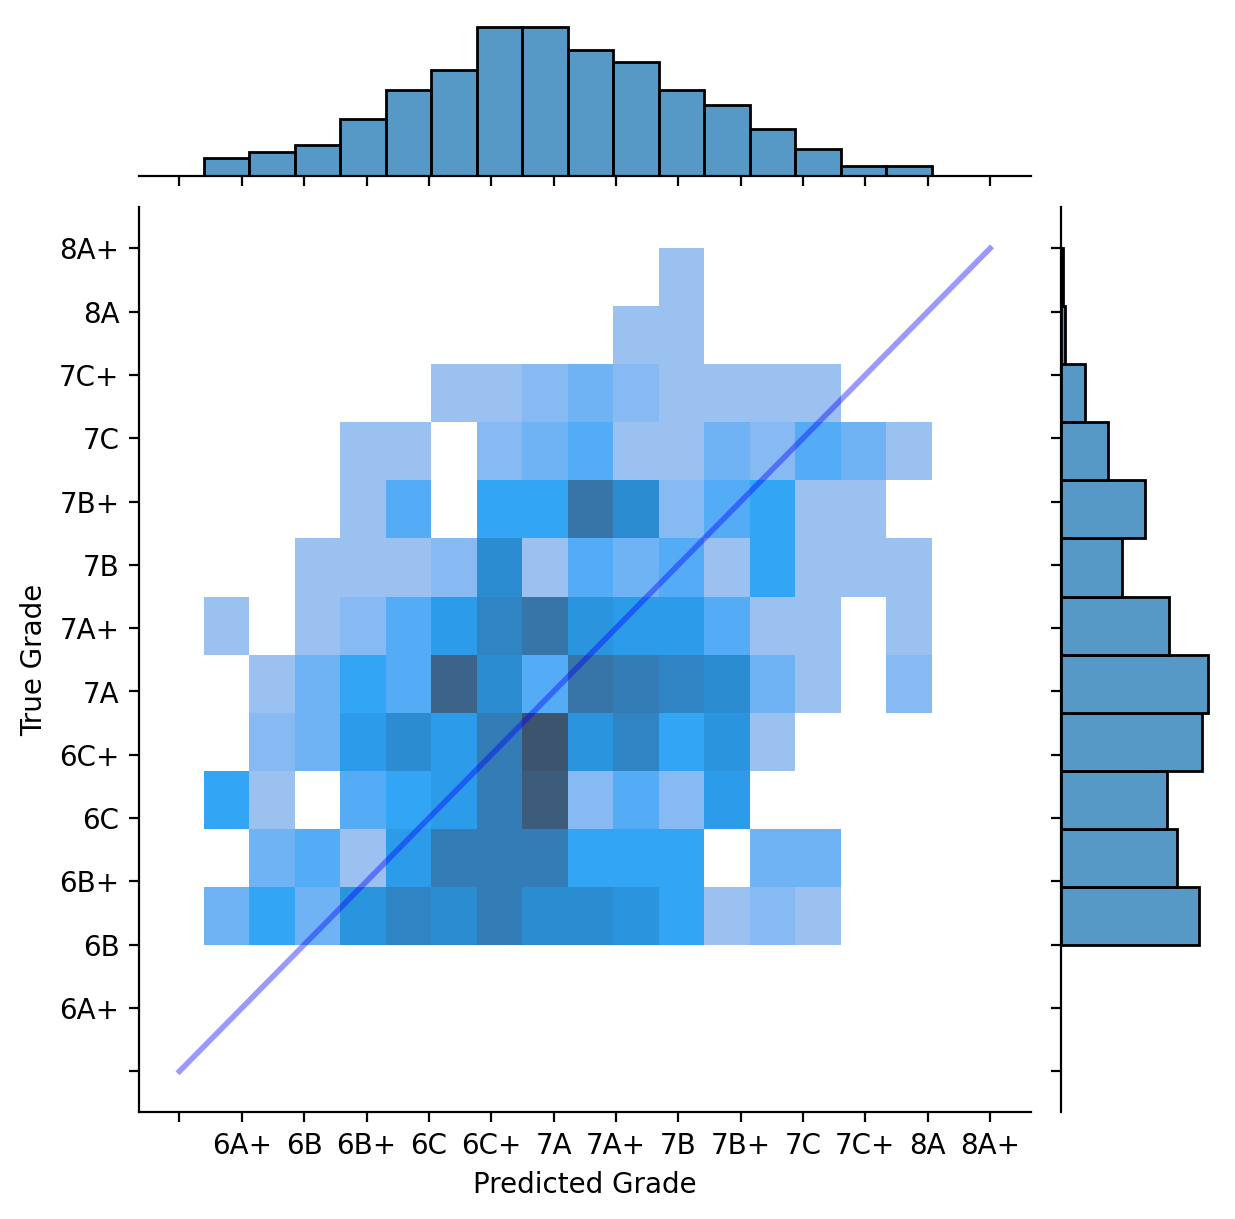

{'train_mae': 2.0620513003519836, 'train_rmse': 2.60110770934232, 'test_mae': 2.2869830812336107, 'test_rmse': 2.815727191375255}

18/18 [==============================] - 0s 859us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2017 40.json', 't2': 'problems MoonBoard Masters 2019 40.json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 2.2869830812336107, 'test_rmse': 2.815727191375255}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2017 40.json', 't2': 'problems MoonBoard Masters 2019 40.json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 5.5572951150383085, 'test_rmse': 6.10748

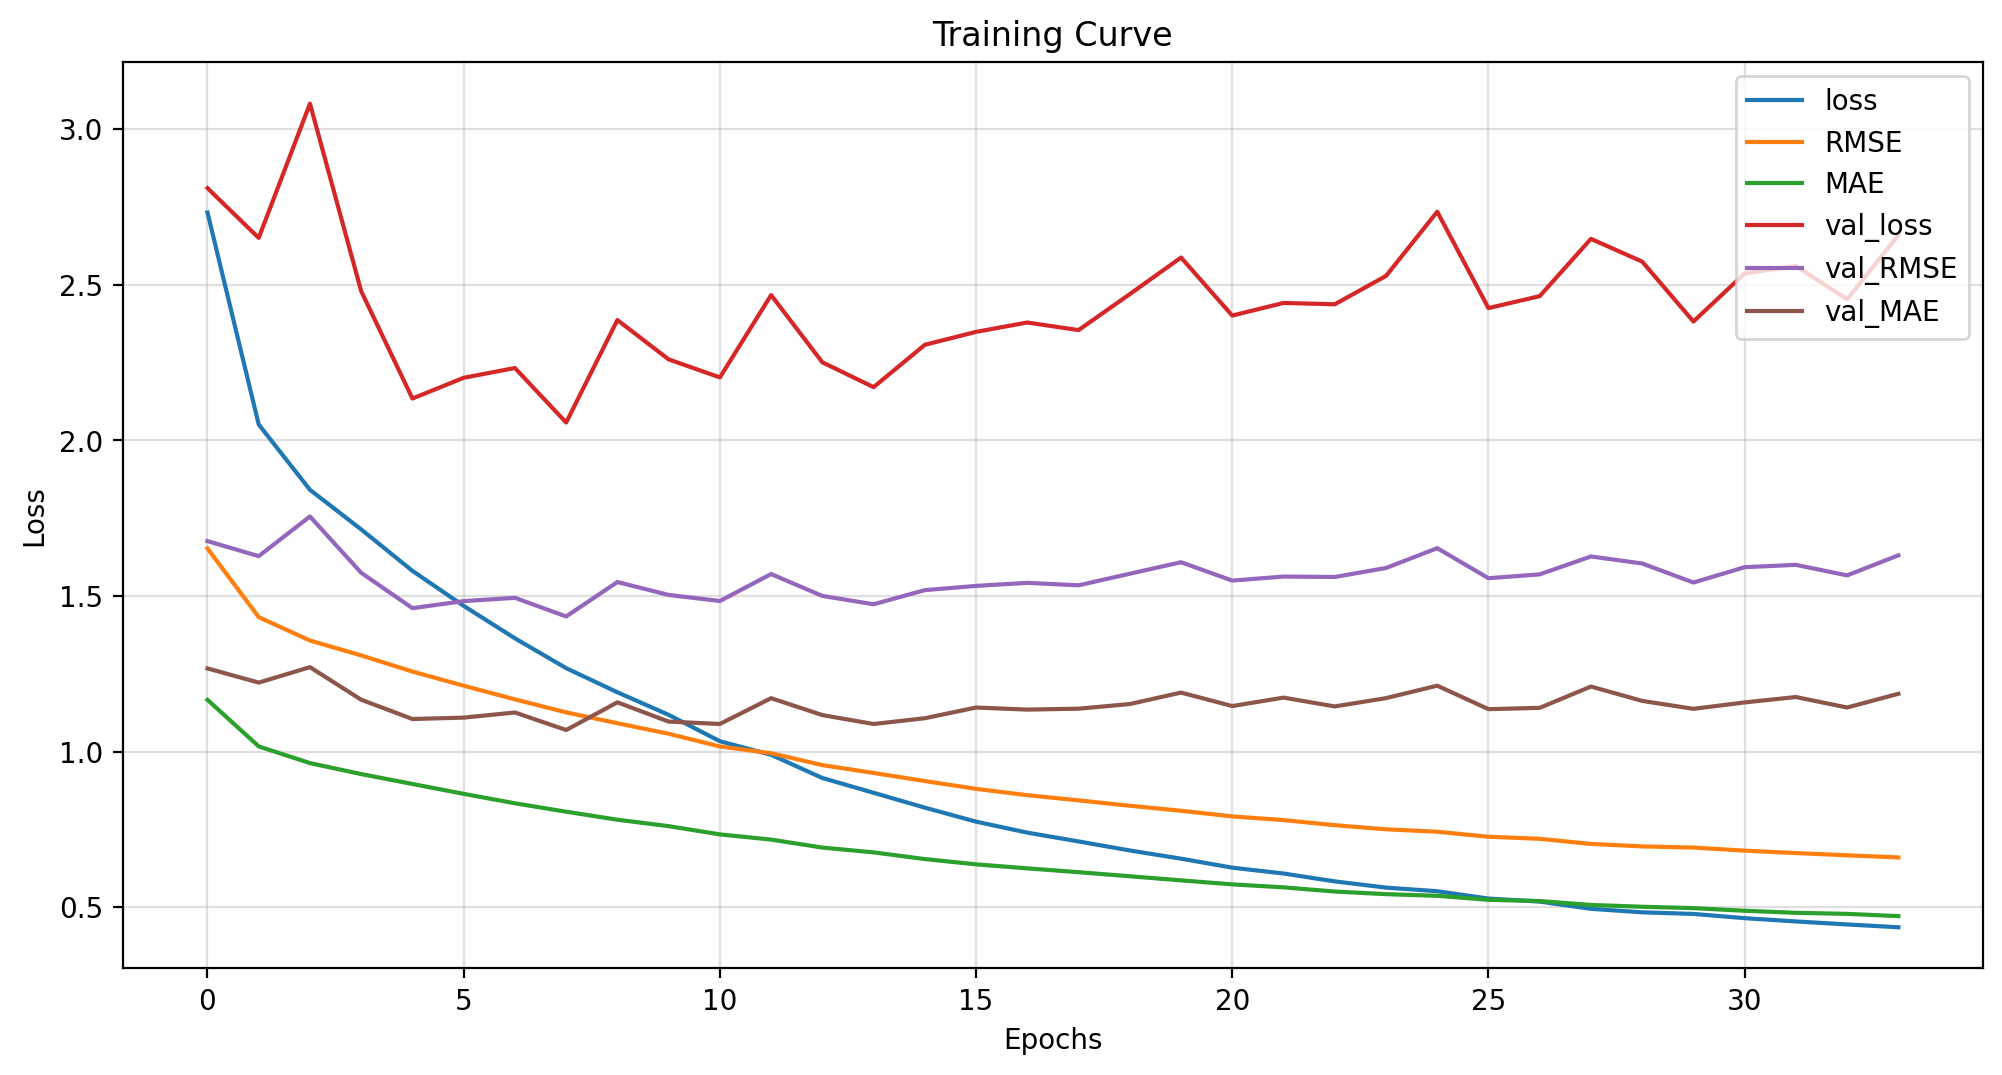

Time to Fit: 631.0845639705658
18/18 [==============================] - 0s 2ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


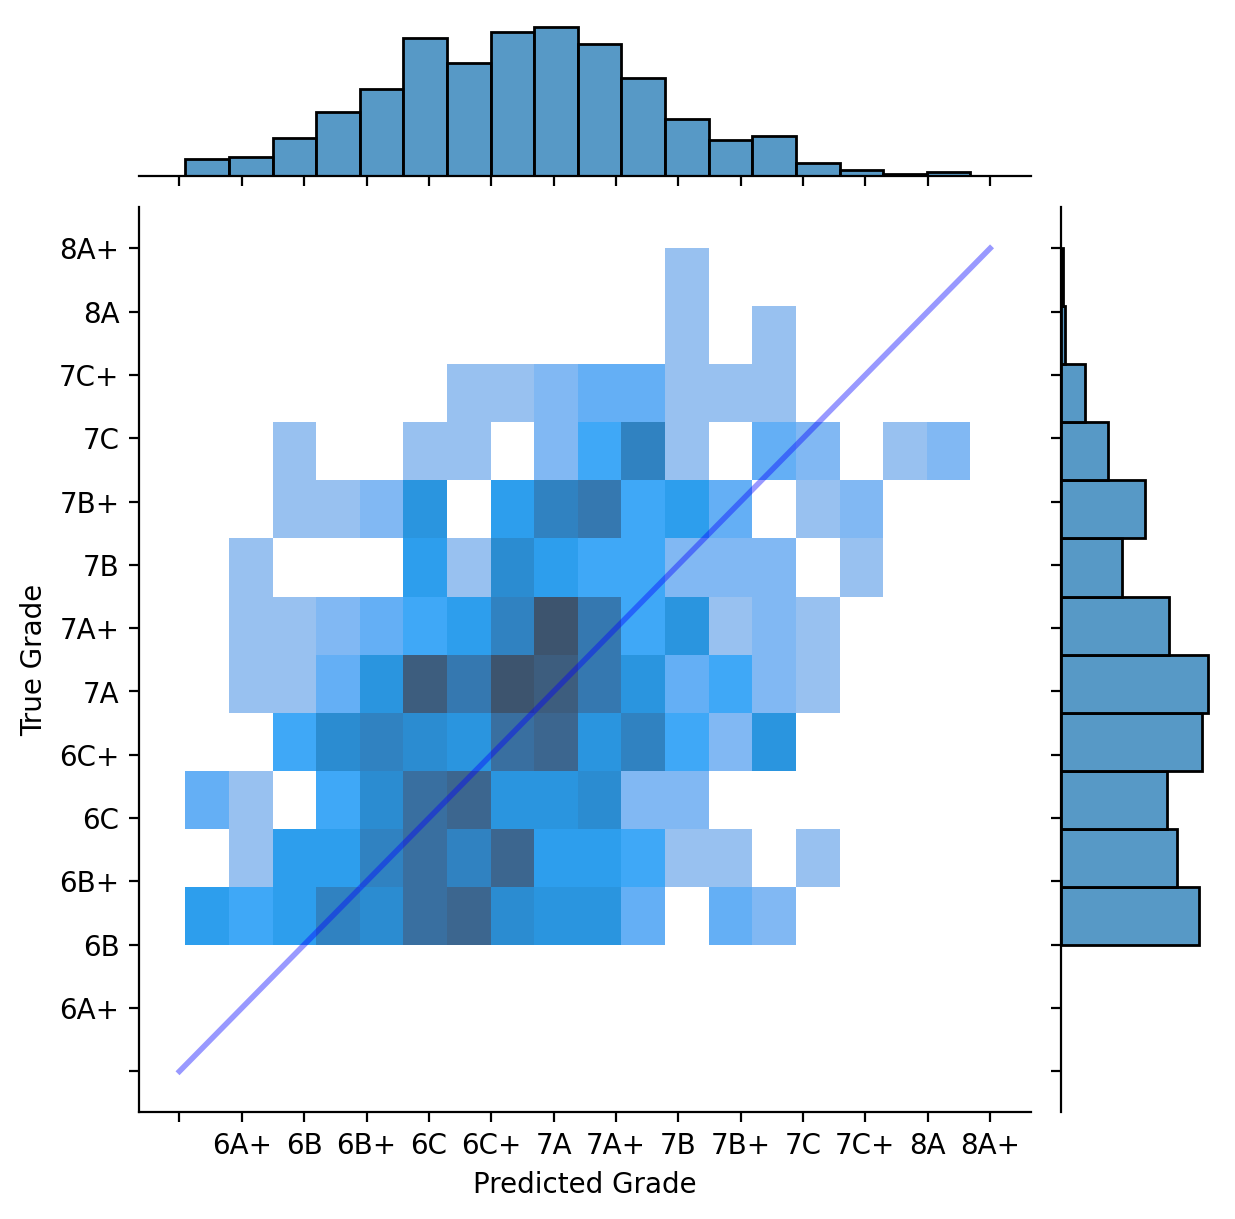

{'train_mae': 1.9018447869789148, 'train_rmse': 2.4338562353906794, 'test_mae': 2.0843424069772074, 'test_rmse': 2.6025434387963466}

18/18 [==============================] - 0s 902us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2017 40.json', 't2': 'problems MoonBoard Masters 2019 40.json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 2.2869830812336107, 'test_rmse': 2.815727191375255}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2017 40.json', 't2': 'problems MoonBoard Masters 2019 40.json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 2.0843424069772074, 'test_rmse': 2.60

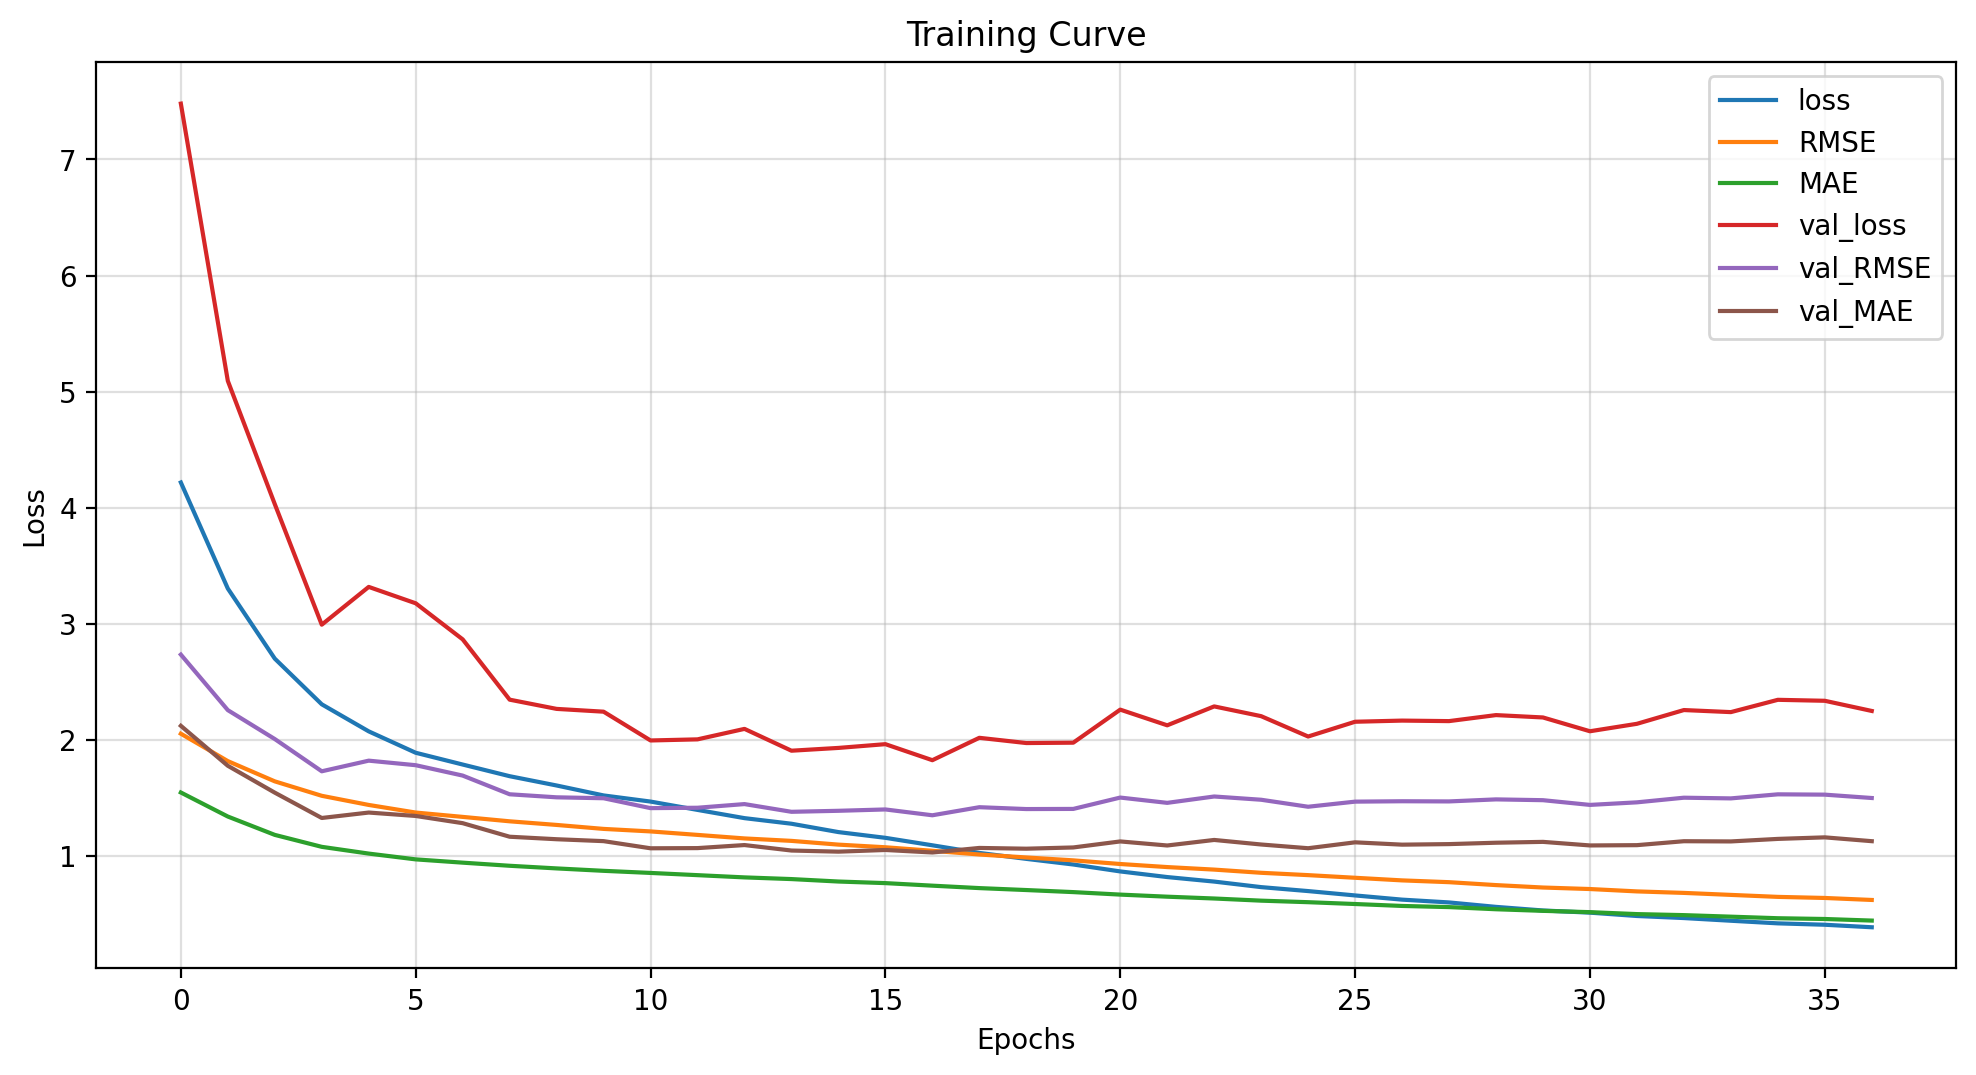

Time to Fit: 1065.3565876483917
18/18 [==============================] - 0s 3ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


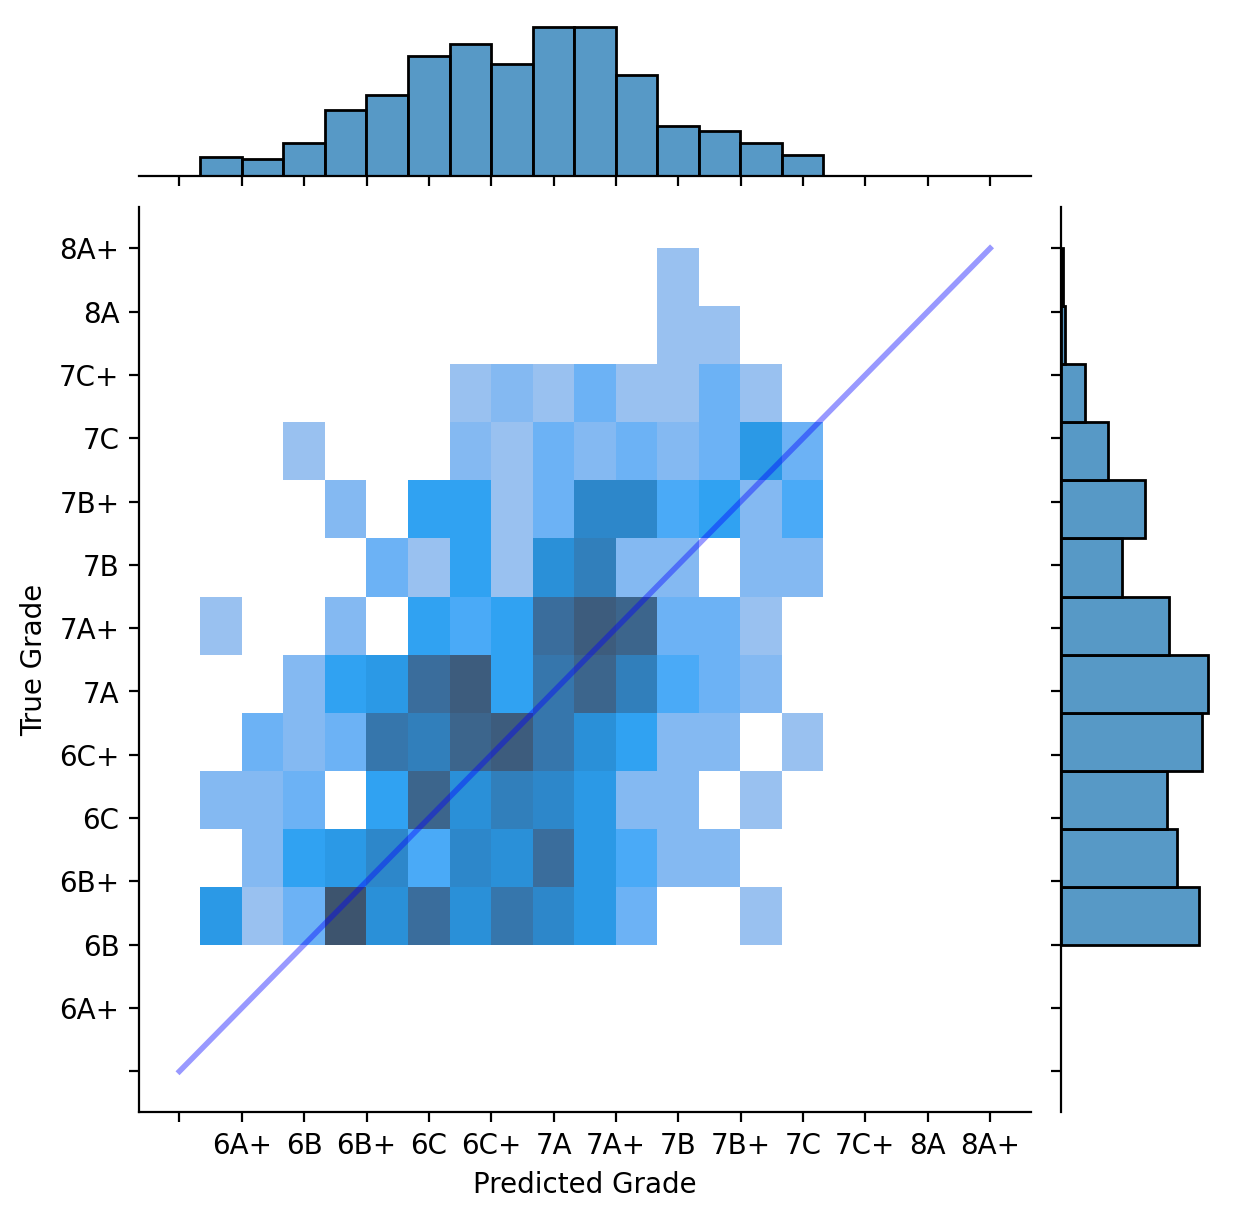

{'train_mae': 1.6567022709208314, 'train_rmse': 2.1208882662108155, 'test_mae': 1.9136323789937781, 'test_rmse': 2.408708779339997}

18/18 [==============================] - 0s 795us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2017 40.json', 't2': 'problems MoonBoard Masters 2019 40.json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 2.2869830812336107, 'test_rmse': 2.815727191375255}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2017 40.json', 't2': 'problems MoonBoard Masters 2019 40.json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 2.0843424069772074, 'test_rmse': 2.602

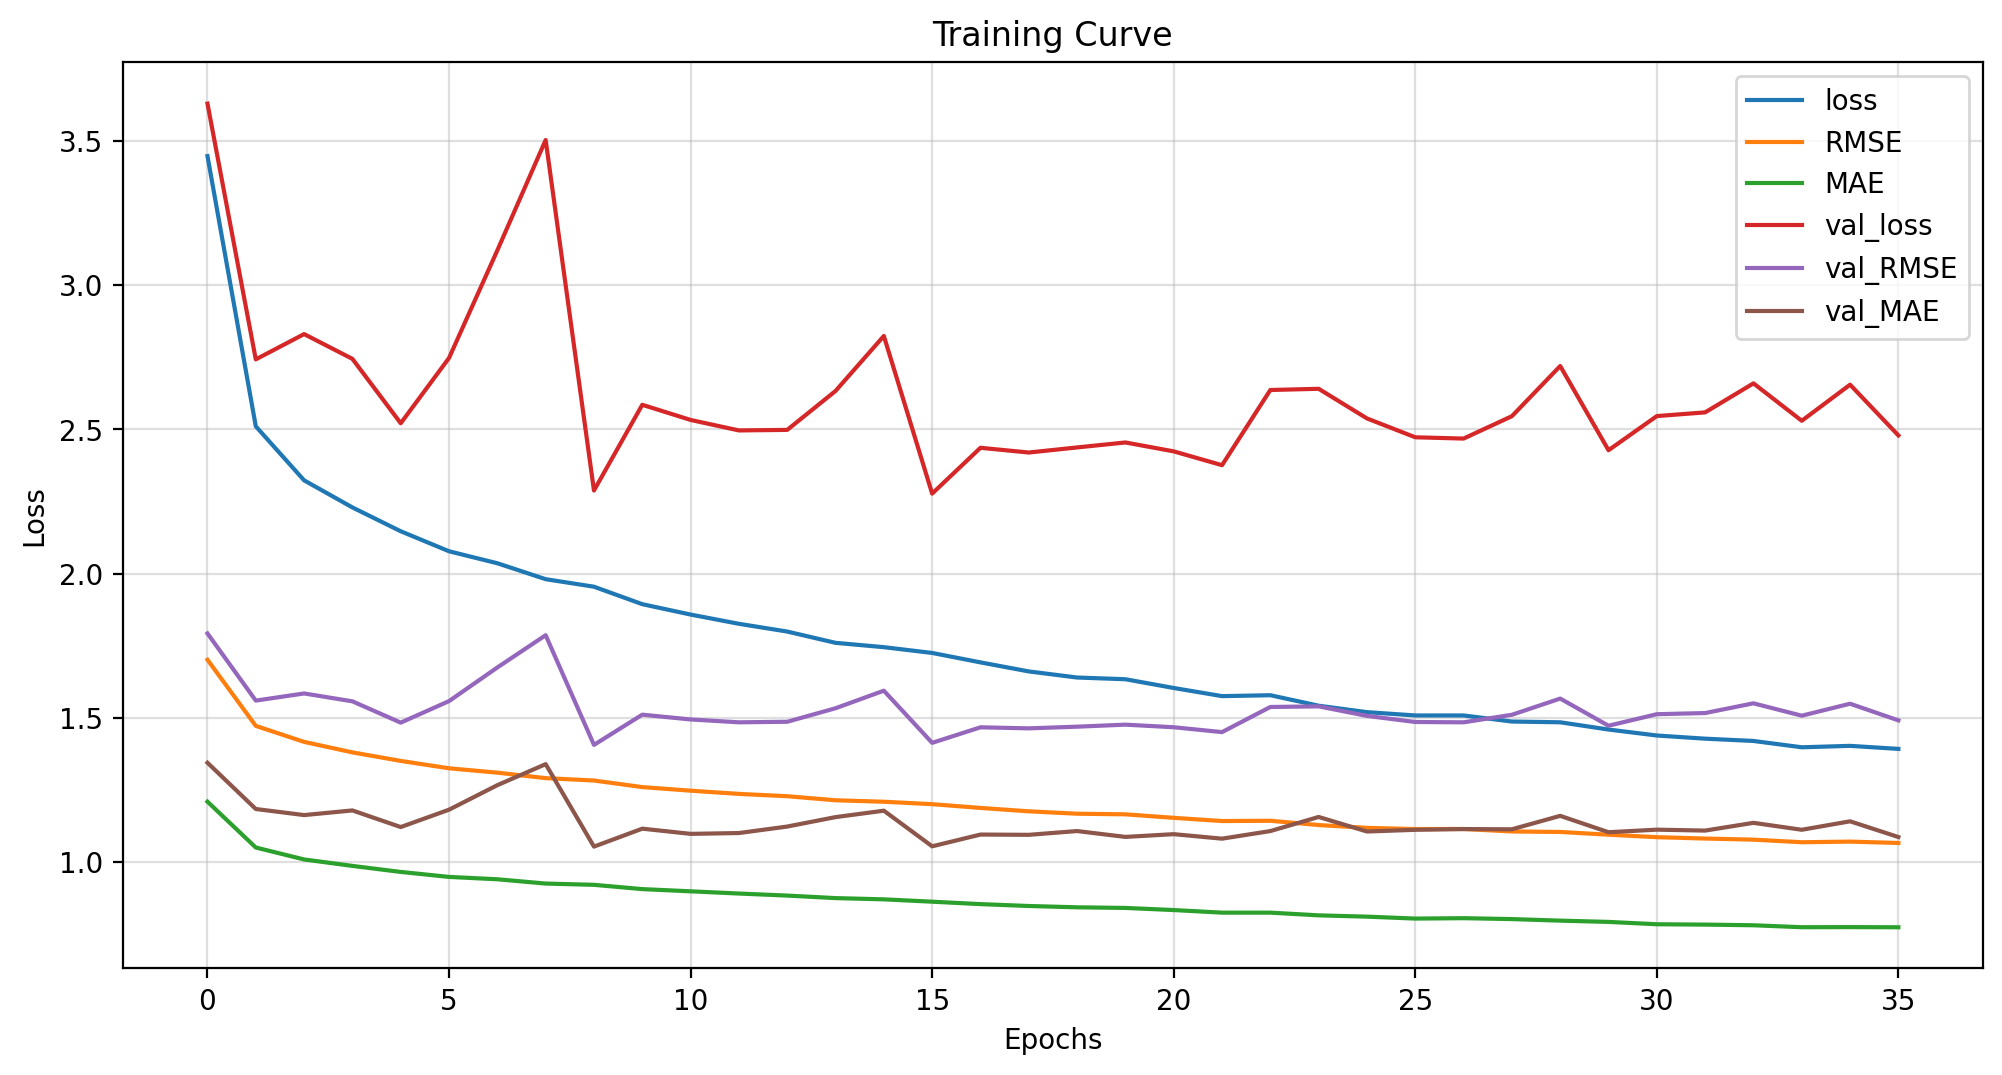

Time to Fit: 2322.8040652275085
18/18 [==============================] - 0s 7ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


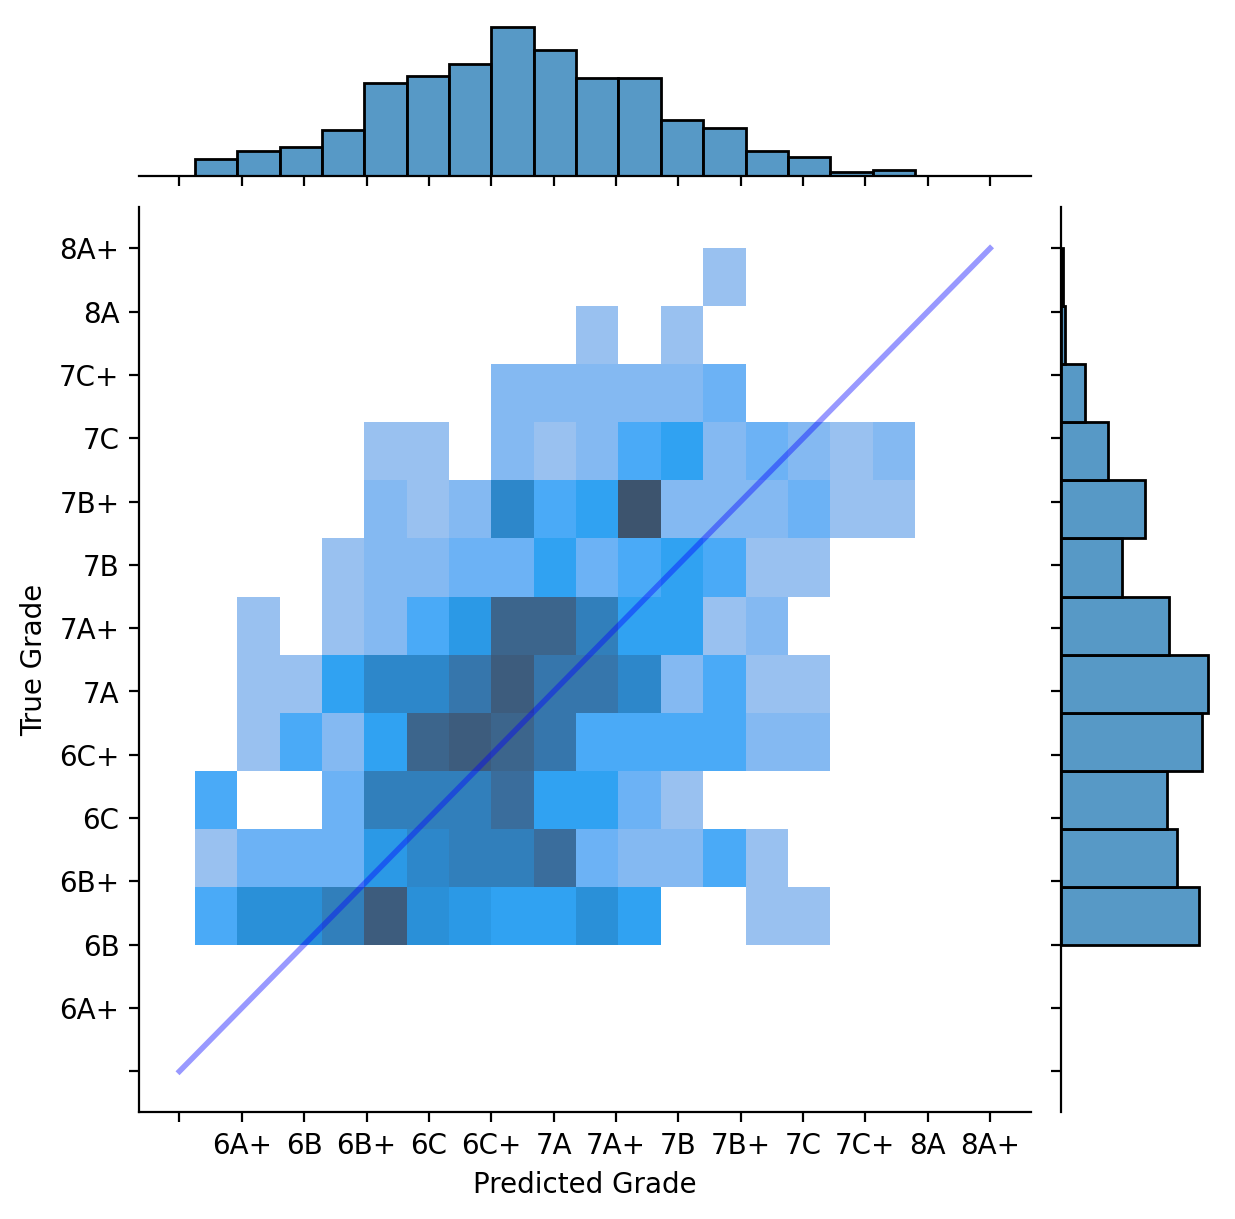

{'train_mae': 1.7022504133794112, 'train_rmse': 2.2127860012192784, 'test_mae': 1.903925240258558, 'test_rmse': 2.408105091242195}

18/18 [==============================] - 0s 771us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2017 40.json', 't2': 'problems MoonBoard Masters 2019 40.json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 2.2869830812336107, 'test_rmse': 2.815727191375255}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2017 40.json', 't2': 'problems MoonBoard Masters 2019 40.json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 2.0843424069772074, 'test_rmse': 2.6025

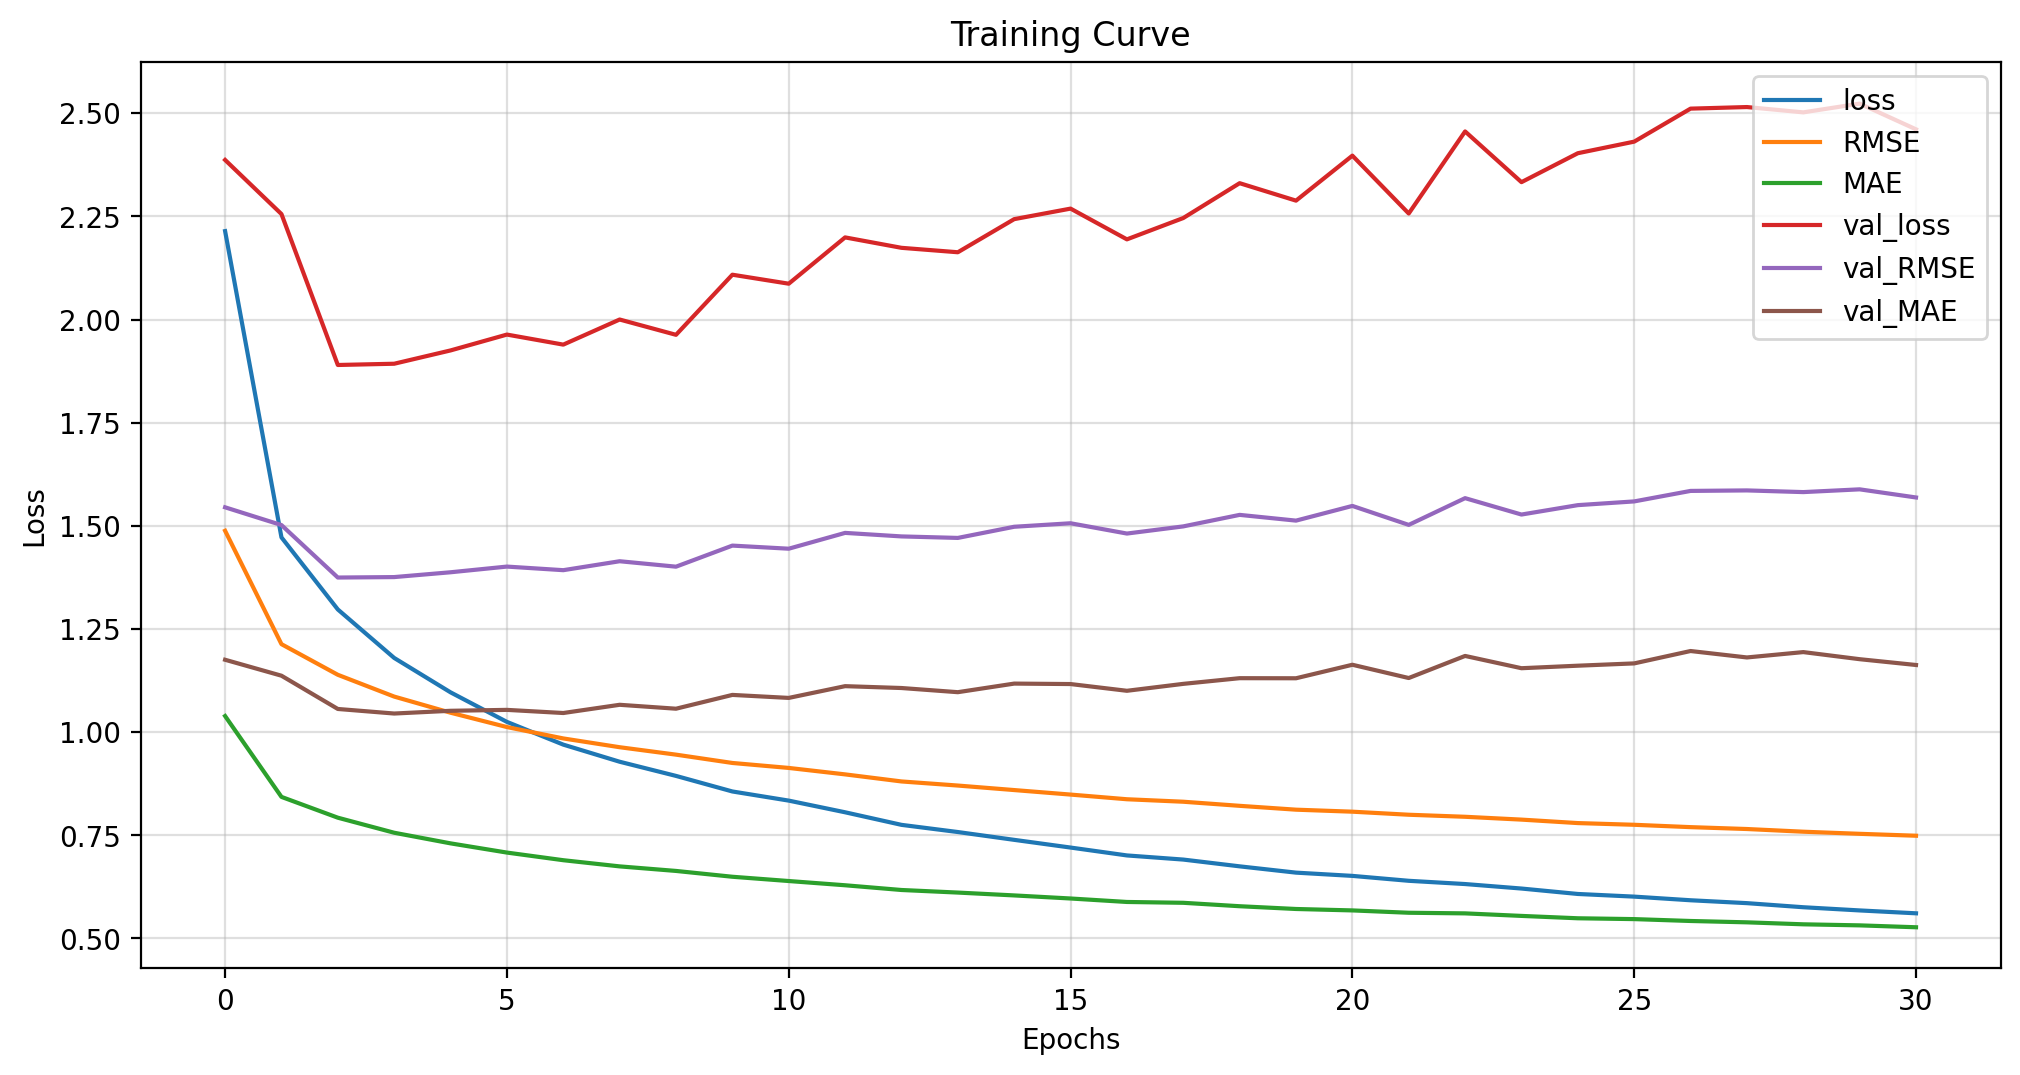

Time to Fit: 176.8799433708191
11/11 [==============================] - 0s 855us/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


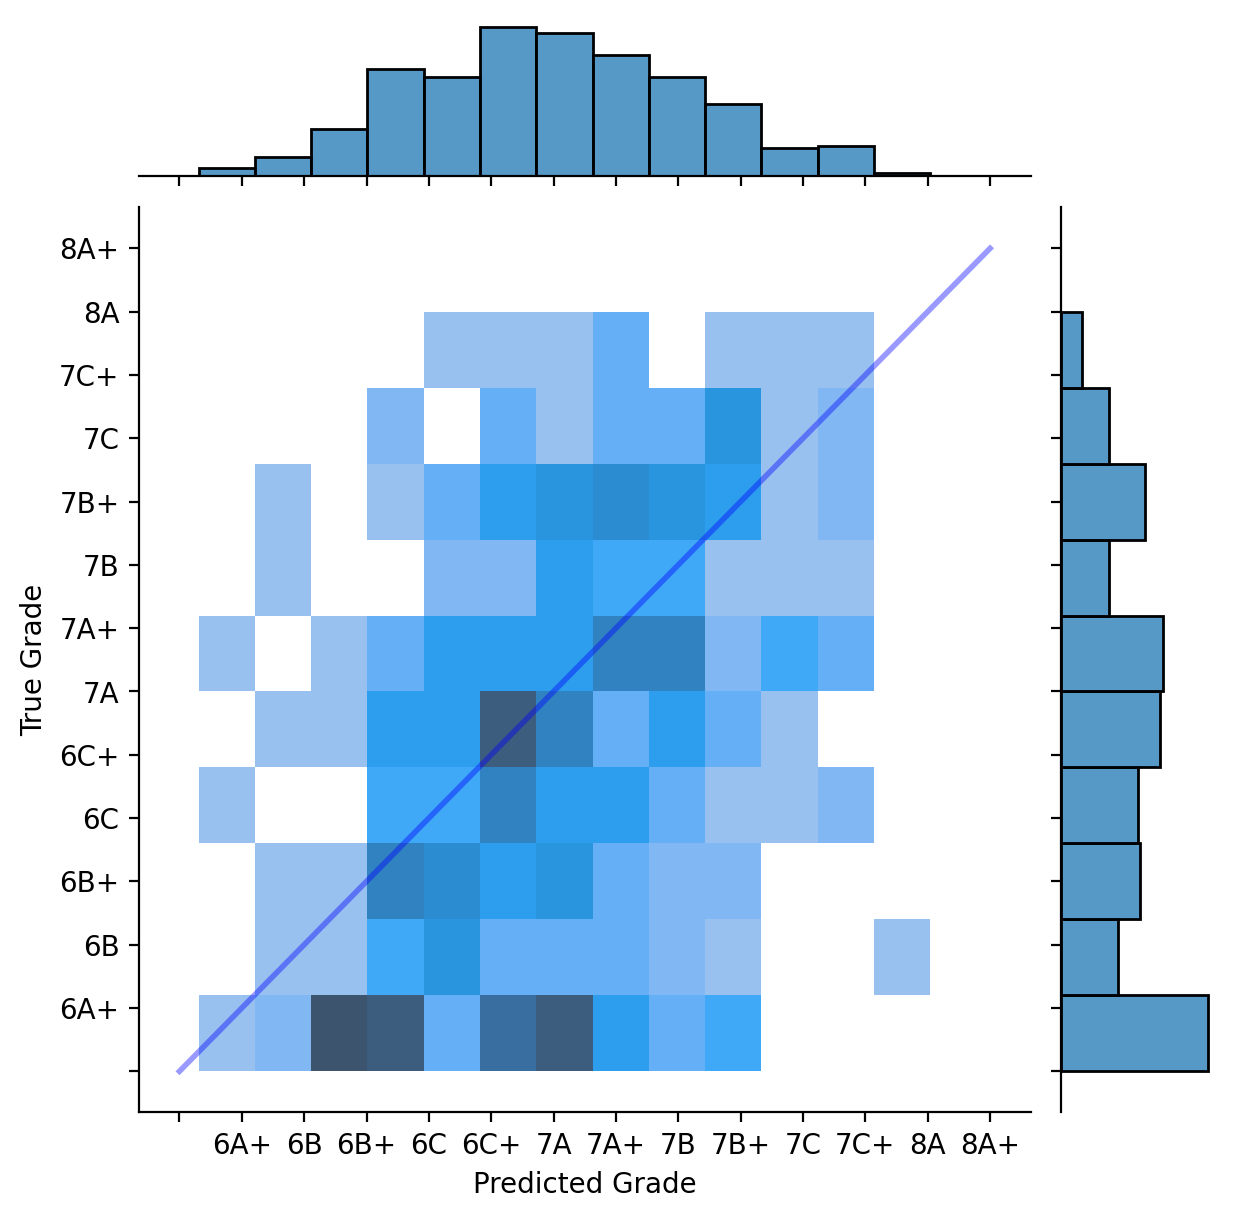

{'train_mae': 3.2742118072520054, 'train_rmse': 3.8344870633281243, 'test_mae': 2.6660178863399087, 'test_rmse': 3.331682131847011}

18/18 [==============================] - 0s 787us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2019 40.json', 't2': 'problems MoonBoard 2016 .json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.993725063822685, 'test_rmse': 1.3037705017159833}

18/18 [==============================] - 0s 3ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2019 40.json', 't2': 'problems MoonBoard 2016 .json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 5.544796685603396, 'test_rmse': 6.098588342704849}

18/18 

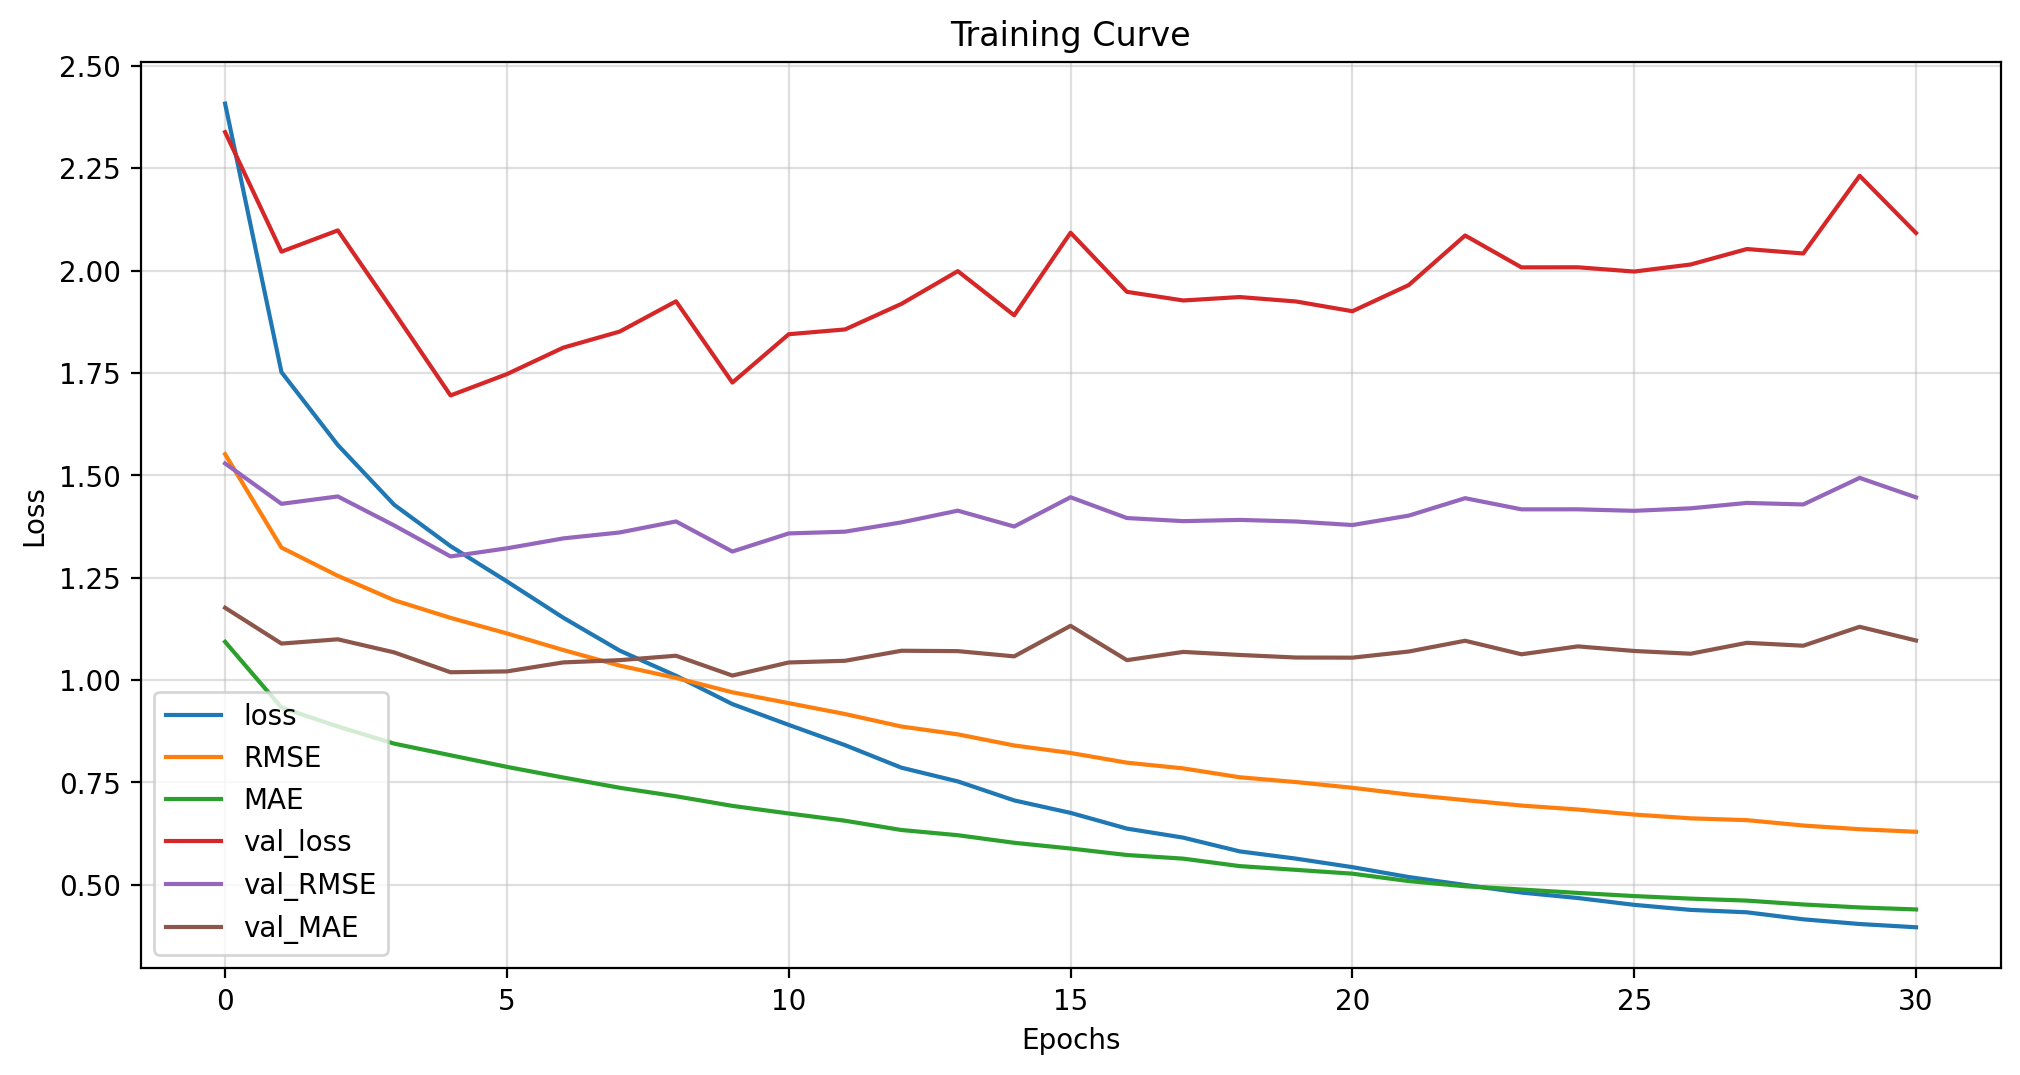

Time to Fit: 645.2836334705353
11/11 [==============================] - 0s 2ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


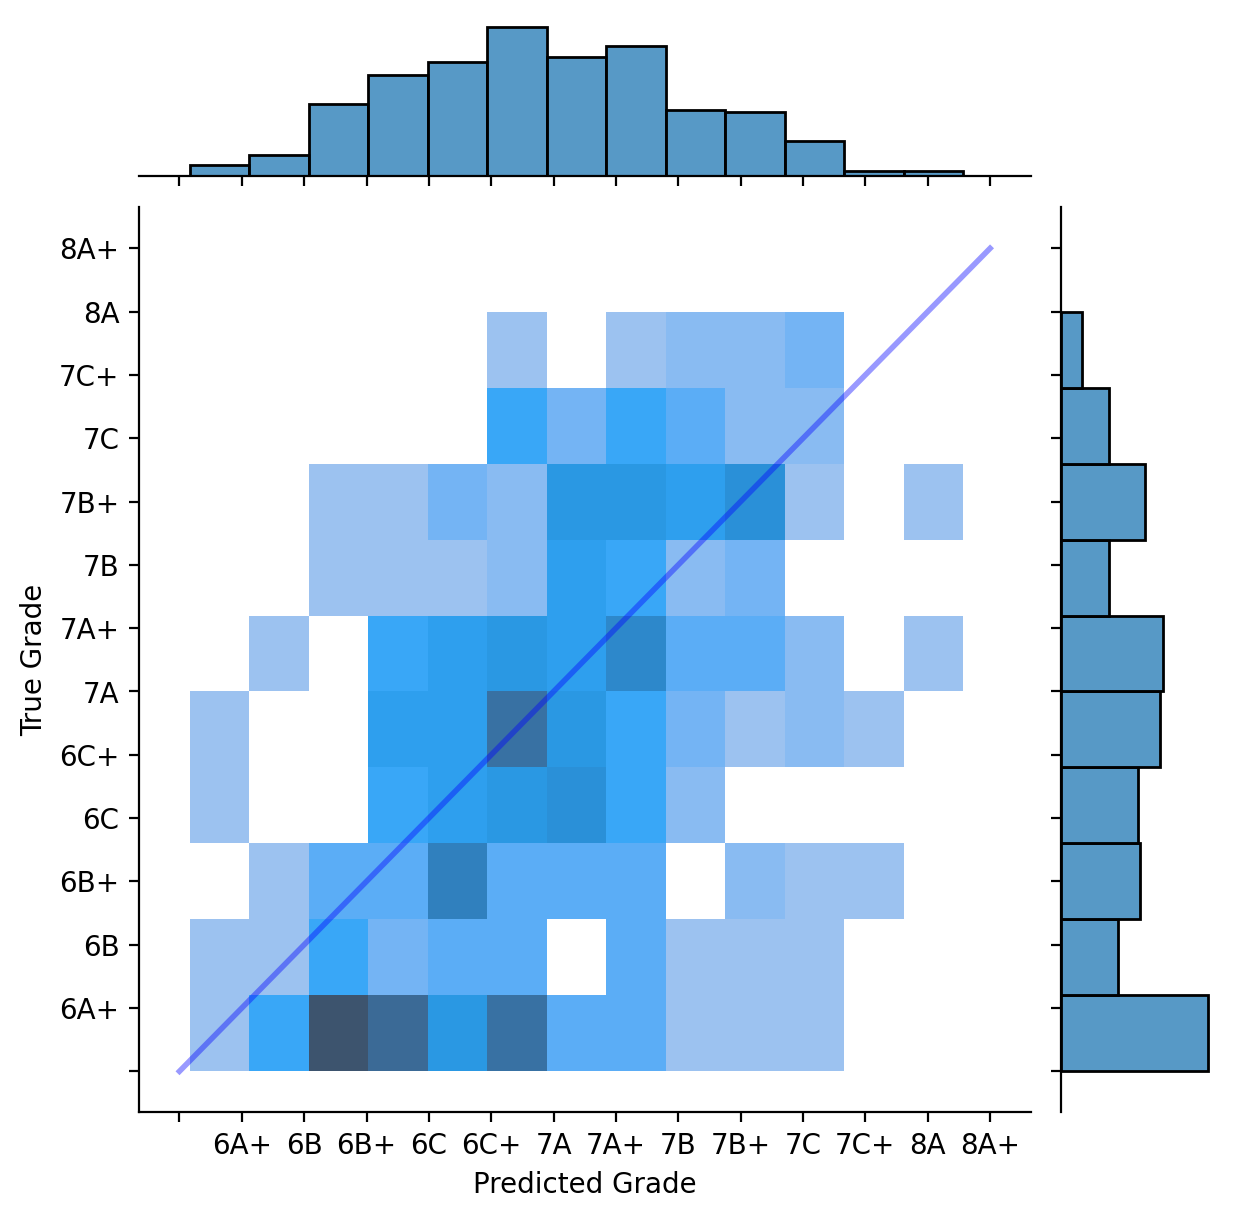

{'train_mae': 3.1095915534056857, 'train_rmse': 3.650419076959686, 'test_mae': 2.399899103279625, 'test_rmse': 3.037451943697672}

18/18 [==============================] - 0s 801us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2019 40.json', 't2': 'problems MoonBoard 2016 .json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.993725063822685, 'test_rmse': 1.3037705017159833}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2019 40.json', 't2': 'problems MoonBoard 2016 .json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.9655346454830345, 'test_rmse': 1.2546100920893881}

18/18 

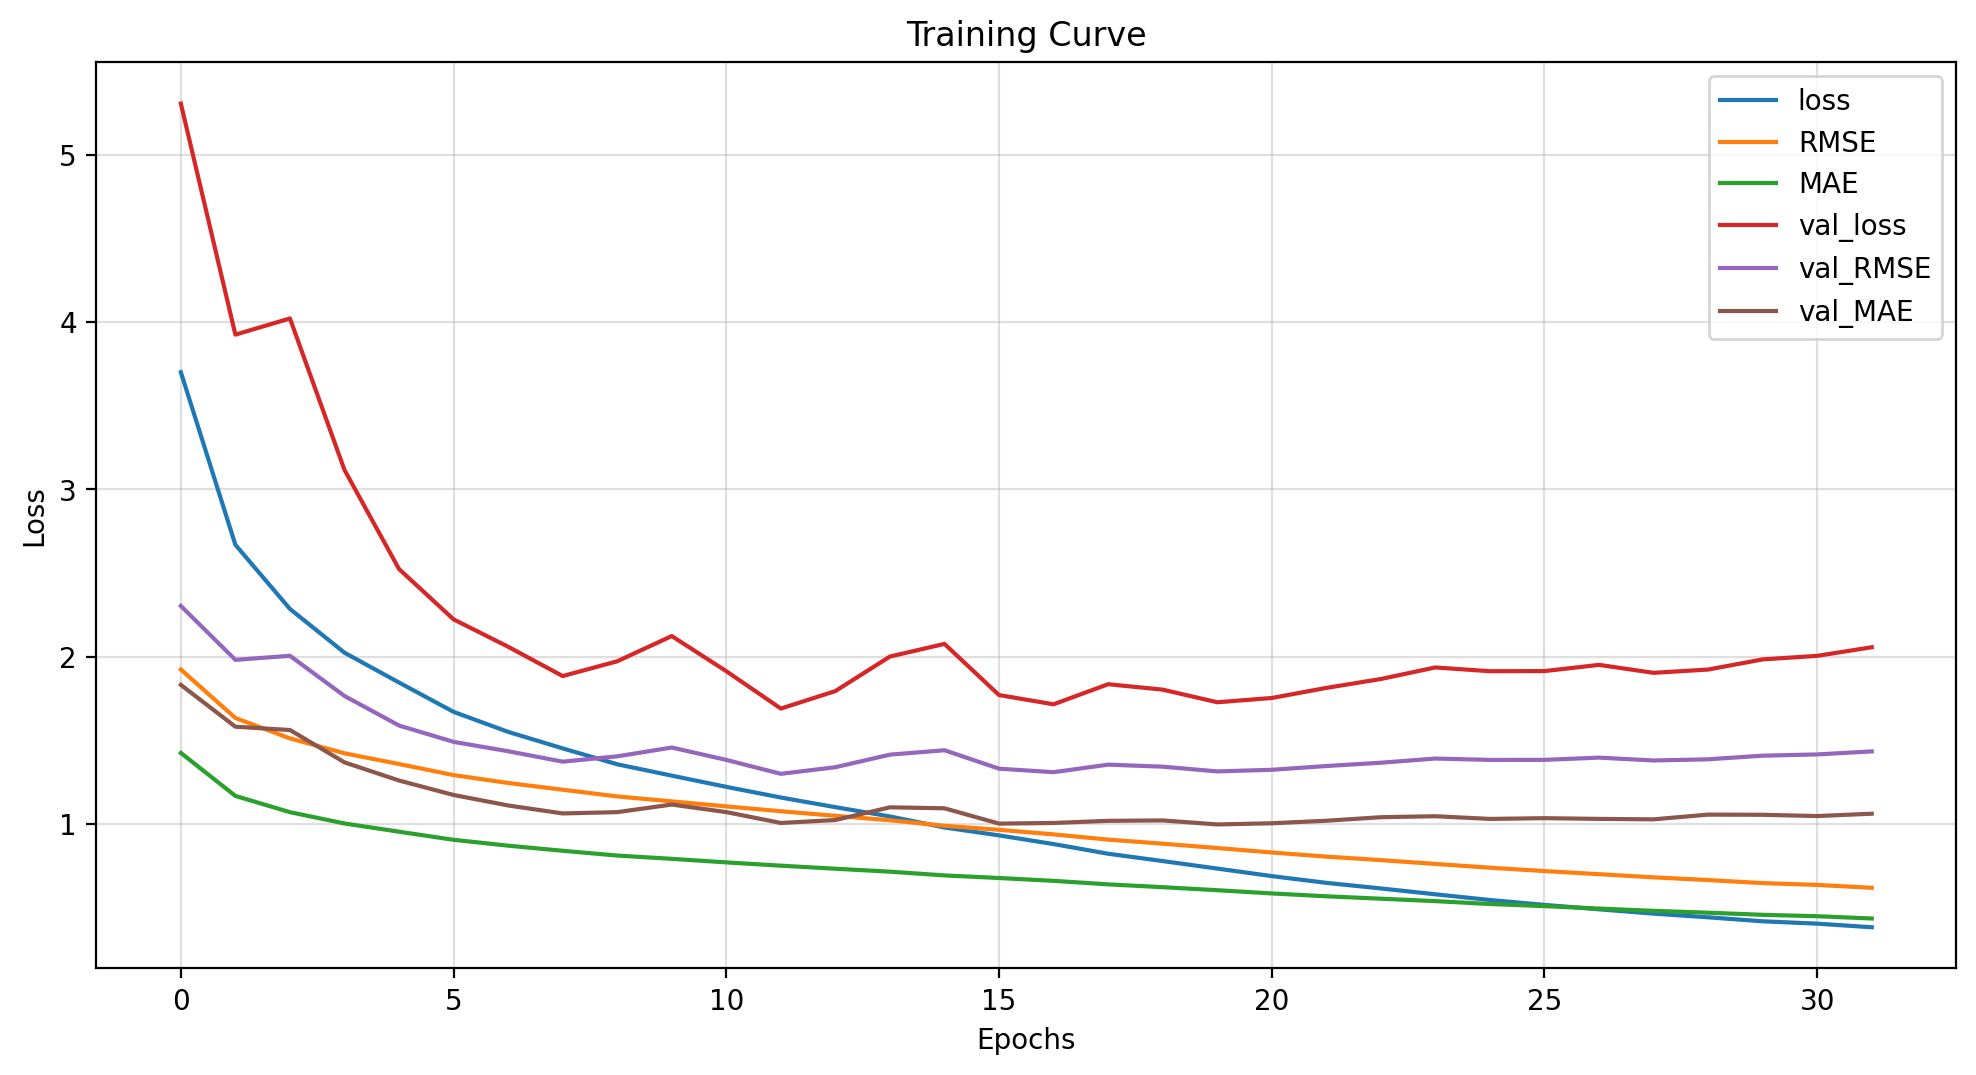

Time to Fit: 1030.6024429798126
11/11 [==============================] - 0s 4ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


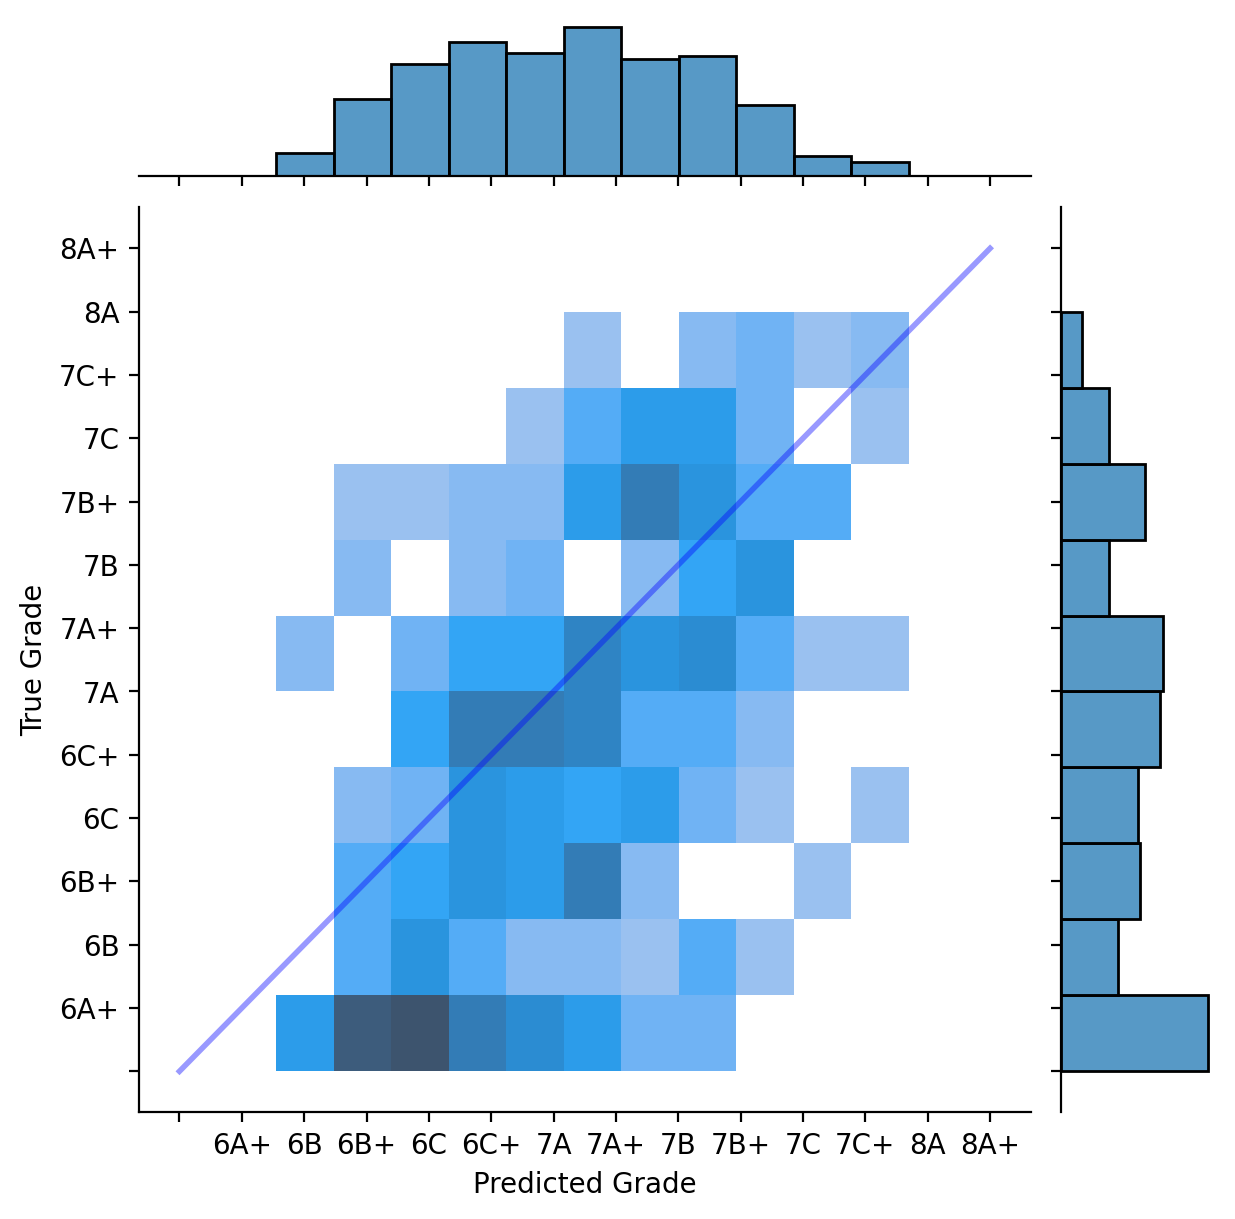

{'train_mae': 3.0555789747762545, 'train_rmse': 3.5217262371173454, 'test_mae': 2.4034511141833805, 'test_rmse': 2.989355873519088}

18/18 [==============================] - 0s 796us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2019 40.json', 't2': 'problems MoonBoard 2016 .json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.993725063822685, 'test_rmse': 1.3037705017159833}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2019 40.json', 't2': 'problems MoonBoard 2016 .json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.9655346454830345, 'test_rmse': 1.2546100920893881}

18/1

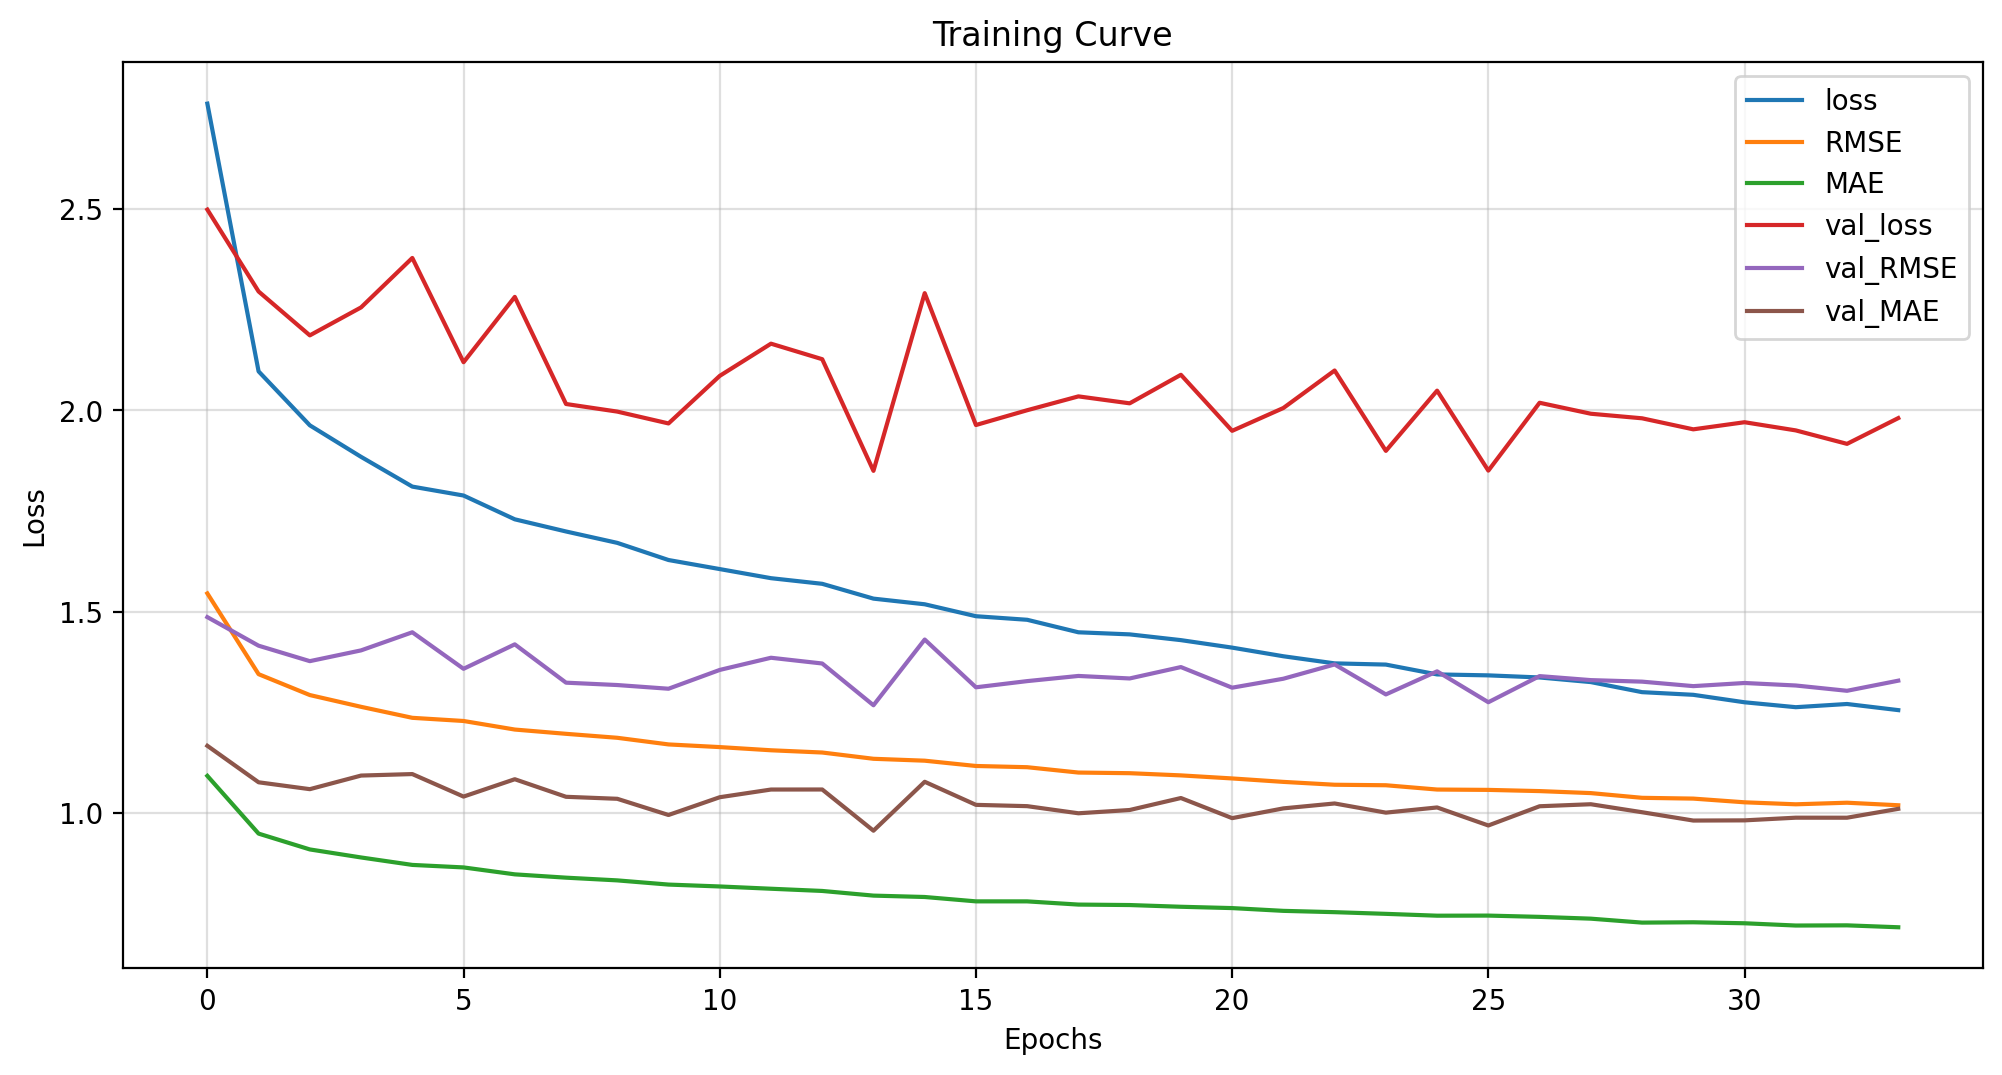

Time to Fit: 2477.680217027664
11/11 [==============================] - 0s 7ms/step


/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


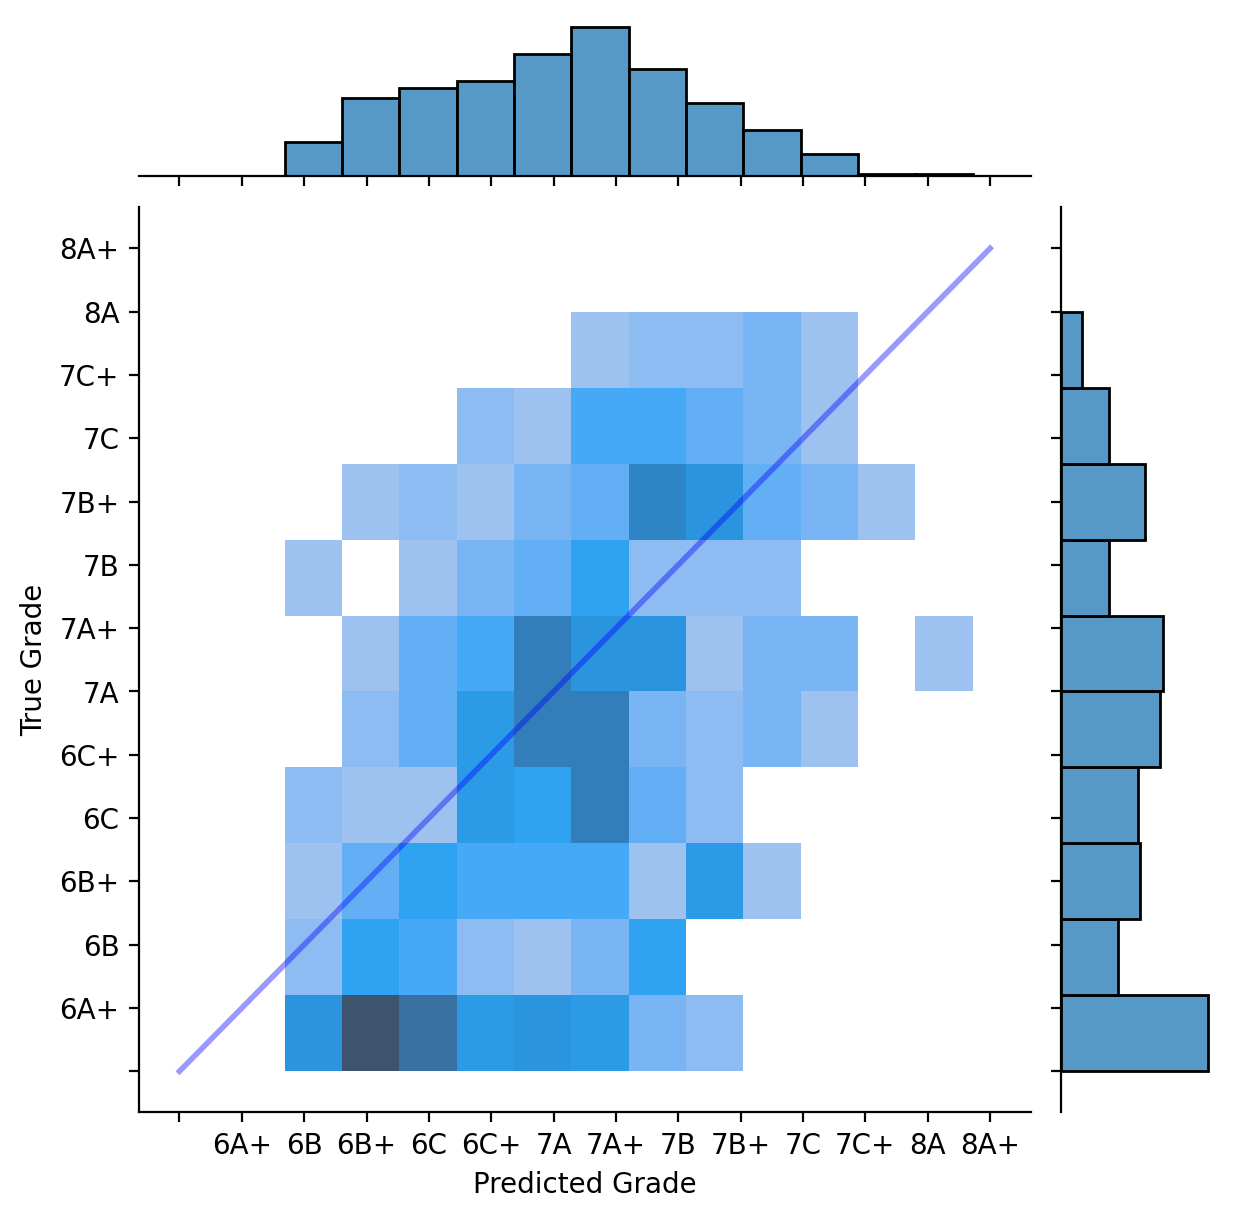

{'train_mae': 3.251079456886101, 'train_rmse': 3.7361518613277274, 'test_mae': 2.467115385546571, 'test_rmse': 3.0402511109521786}

18/18 [==============================] - 0s 759us/step 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2019 40.json', 't2': 'problems MoonBoard 2016 .json', 'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.993725063822685, 'test_rmse': 1.3037705017159833}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'t1': 'problems MoonBoard Masters 2019 40.json', 't2': 'problems MoonBoard 2016 .json', 'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.9655346454830345, 'test_rmse': 1.2546100920893881}

18/18

In [11]:
transfer_results = []

for setup in combinations:
    print( setup )
    t1 = paths[setup[0]]
    t2 = paths[setup[1]]
    t3 = paths[setup[2]]
    
    X1, y1, X1_t, y1_t = getDataset( t1 )
    X2, y2, X2_t, y2_t = getDataset( t2 )
    X3, y3, X3_t, y3_t = getDataset( t3 )

    models = getModels() # Get fresh models
    model_names = [ 'DNN', '2DCNN', 'LSTM', 'DNN+2DCNN' ]

    scores = []

    for model, model_name in zip( models, model_names ):
        print( model_name )
        start_time = time.time()
        history = model.fit( 
            np.concatenate( ( X1, X2 ), axis = 0 ),
            np.concatenate( ( y1, y2 ), axis = 0 ),
            validation_data = ( np.concatenate( ( X1_t, X2_t ), axis = 0 ), np.concatenate( ( y1_t, y2_t ), axis = 0 ) ),
            # sample_weight = np.log( train_repeats ) + 1,
            # class_weight = class_weights,
            epochs = 200,
            batch_size = 8,
            # verbose = 0,
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor = "val_loss",
                    patience = 20,
                    restore_best_weights = True,
                    start_from_epoch = 10,
                )
            ]
        )

        for key in history.history.keys():
            plt.plot( history.history[key] )
        plt.legend( list( history.history.keys() ) )
        plt.title( 'Training Curve' )
        plt.xlabel( 'Epochs' )
        plt.ylabel( 'Loss' )
        plt.grid( alpha = 0.4 )
        plt.show()

        timestamp = time.time() - start_time
        print( 'Time to Fit:', timestamp )

        train_predictions = model.predict( X3 )
        predictions = model.predict( X3_t )

        scores.append( evaluate( train_predictions, predictions, y3, y3_t, plot_predictions = True ) )
        print( scores[-1] )
        print()
        
        for path in paths:
            for model_name, model in zip( model_names, models ):
                x, y = getTest( path )
                predictions = model.predict( x )

                d = {
                    't1': t1,
                    't2': t2,
                    'Model': model_name,
                    'Dataset': path,
                }

                d = d | evaluate( [ 0 ], predictions, [ 0 ], y, plot_predictions = False )

                transfer_results.append( d )
                print( transfer_results[-1] )
                print()

In [12]:
transfer_results = pd.DataFrame( transfer_results )

names = {
    'train_mae': 'Training MAE',
    'train_rmse': 'Training RMSE',
    'test_mae': 'Testing MAE',
    'test_rmse': 'Testing RMSE',
    'Model': 'Model Name',
}

transfer_results = transfer_results.rename( columns = names )

display( transfer_results )

,t1,t2,Model Name,Dataset,Training MAE,Training RMSE,Testing MAE,Testing RMSE
0,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,DNN,problems MoonBoard 2016 .json,0.0,0.0,0.986919,1.285637
1,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,2DCNN,problems MoonBoard 2016 .json,0.0,0.0,5.560800,6.111731
2,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,LSTM,problems MoonBoard 2016 .json,0.0,0.0,5.556450,6.107712
3,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,DNN+2DCNN,problems MoonBoard 2016 .json,0.0,0.0,5.554432,6.105961
4,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,DNN,problems MoonBoard Masters 2017 40.json,0.0,0.0,1.070649,1.440435
...,...,...,...,...,...,...,...,...
139,problems MoonBoard Masters 2019 40.json,problems MoonBoard 2016 .json,DNN+2DCNN,problems MoonBoard Masters 2017 40.json,0.0,0.0,2.467115,3.040251
140,problems MoonBoard Masters 2019 40.json,problems MoonBoard 2016 .json,DNN,problems MoonBoard Masters 2019 40.json,0.0,0.0,1.210007,1.624077
141,problems MoonBoard Masters 2019 40.json,problems MoonBoard 2016 .json,2DCNN,problems MoonBoard Masters 2019 40.json,0.0,0.0,1.153346,1.493267
142,problems MoonBoard Masters 2019 40.json,problems MoonBoard 2016 .json,LSTM,problems MoonBoard Masters 2019 40.json,0.0,0.0,1.049883,1.360660


In [ ]:
36:48
84:96
132:144

In [18]:
display( transfer_results.iloc[36:48] )

,t1,t2,Model Name,Dataset,Training MAE,Training RMSE,Testing MAE,Testing RMSE
36,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,DNN,problems MoonBoard 2016 .json,0.0,0.0,0.986919,1.285637
37,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,2DCNN,problems MoonBoard 2016 .json,0.0,0.0,1.016241,1.338295
38,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,LSTM,problems MoonBoard 2016 .json,0.0,0.0,0.923808,1.178574
39,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,DNN+2DCNN,problems MoonBoard 2016 .json,0.0,0.0,0.952250,1.242332
40,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,DNN,problems MoonBoard Masters 2017 40.json,0.0,0.0,1.070649,1.440435
41,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,2DCNN,problems MoonBoard Masters 2017 40.json,0.0,0.0,0.988962,1.287864
42,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,LSTM,problems MoonBoard Masters 2017 40.json,0.0,0.0,0.990404,1.318917
43,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,DNN+2DCNN,problems MoonBoard Masters 2017 40.json,0.0,0.0,0.892674,1.210149
44,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,DNN,problems MoonBoard Masters 2019 40.json,0.0,0.0,2.782519,3.408771
45,problems MoonBoard 2016 .json,problems MoonBoard Masters 2017 40.json,2DCNN,problems MoonBoard Masters 2019 40.json,0.0,0.0,2.671630,3.264308


/tmp/ipykernel_1139677/3053199969.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = pd.melt( transfer_results.iloc[132:144][transfer_results['Dataset'] == path], id_vars = 'Model Name', value_vars = [ 'Testing MAE', 'Testing RMSE' ] ),
/tmp/ipykernel_1139677/3053199969.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = pd.melt( transfer_results.iloc[132:144][transfer_results['Dataset'] == path], id_vars = 'Model Name', value_vars = [ 'Testing MAE', 'Testing RMSE' ] ),
/tmp/ipykernel_1139677/3053199969.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = pd.melt( transfer_results.iloc[132:144][transfer_results['Dataset'] == path], id_vars = 'Model Name', value_vars = [ 'Testing MAE', 'Testing RMSE' ] ),


[]

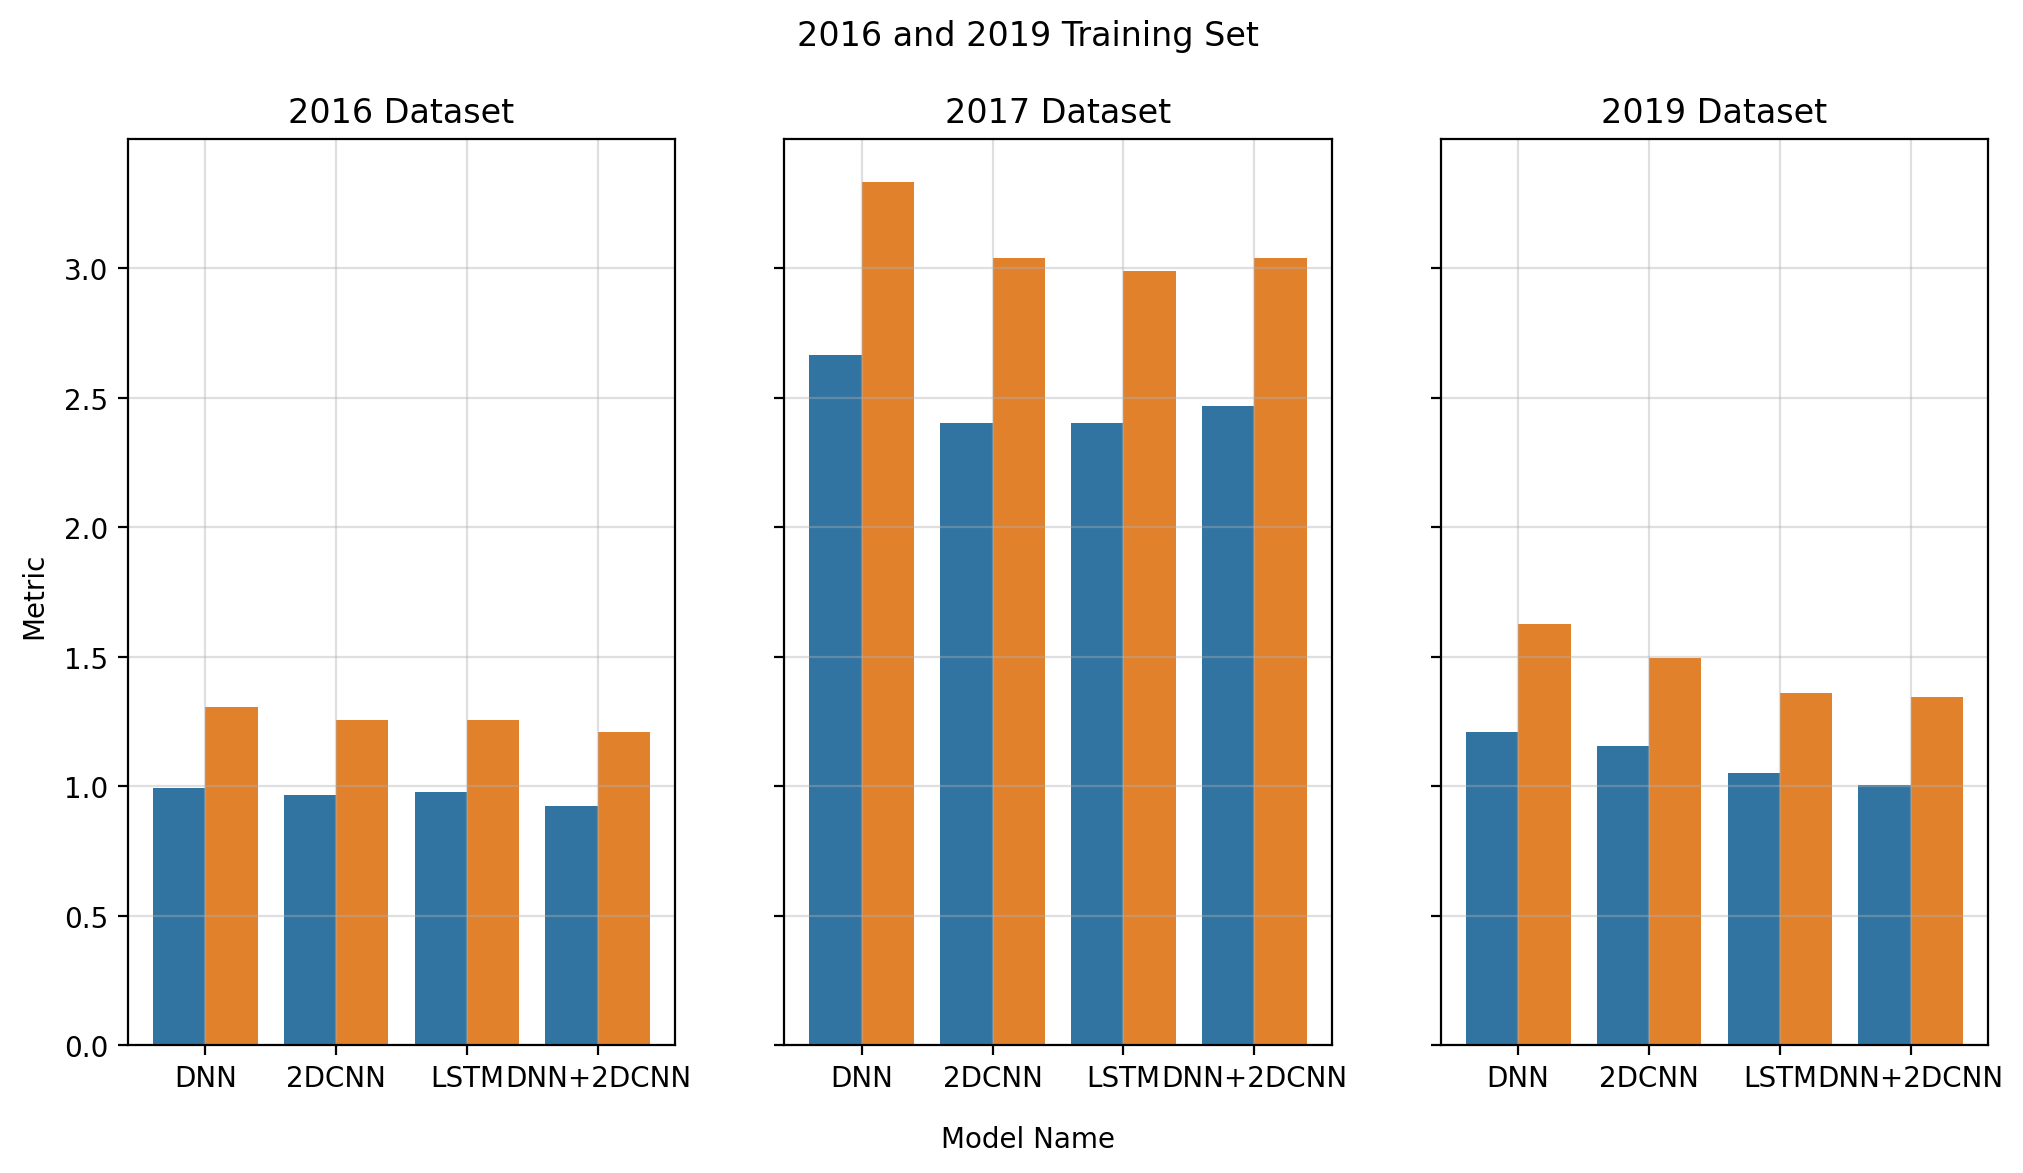

In [28]:
fig, ax = plt.subplots( ncols = 3, sharex = True, sharey = True ) 

names = [ '2016 Dataset', '2017 Dataset', '2019 Dataset' ]

for i, path in enumerate( paths ):
    plot = sns.barplot(
        ax = ax[i],
        data = pd.melt( transfer_results.iloc[132:144][transfer_results['Dataset'] == path], id_vars = 'Model Name', value_vars = [ 'Testing MAE', 'Testing RMSE' ] ),
        y = 'value',
        x = 'Model Name',
        hue = 'variable',
        palette = 'tab10'
    )
    plot.set_title( names[i] )
    ax[i].set_ylabel( '' )
    ax[i].set_xlabel( '' )
    ax[i].grid( alpha = 0.4 )
    ax[i].get_legend().remove()

fig.text( 0.5, 0.04, 'Model Name', ha='center')
fig.text( 0.08, 0.5, 'Metric', va='center', rotation='vertical')

# ax[1].legend( loc = 'upper center' )

plt.suptitle( '2016 and 2019 Training Set' )
plt.plot()

In [30]:
# Pull other datasets and evaluate model performance against them too!

paths = [
    'problems MoonBoard 2016 .json',
    'problems MoonBoard Masters 2017 40.json',
    'problems MoonBoard Masters 2019 40.json',
]

In [31]:
def getTest( path ):
    df = pd.read_json( path )
    l = []
    for i, row in df.iterrows():
        l.append( row['data'] )
    df = pd.DataFrame( l )
    
    # Cleaning:
    df = df[df['repeats'] >= 5 ]
    
    grades = {
        '':   -1,
        '6A+': 0,
        '6B':  1,
        '6B+': 2,
        '6C':  3,
        '6C+': 4,
        '7A':  5,
        '7A+': 6,
        '7B':  7,
        '7B+': 8,
        '7C':  9,
        '7C+': 10,
        '8A':  11,
        '8A+': 12,
        '8B':  13,
        '8B+': 14,
    }
    
    df.fillna( '', inplace = True )
    
    df['grade_index'] = df.apply(
        lambda x: grades[x['grade']], axis = 1
    )
    
    grade, is_benchmark, moves, repeats = [], [], [], []
    for i, row in df.iterrows():
        # row = row['data']
        grade.append(row['grade'])
        is_benchmark.append(row['isBenchmark'])
        moves.append( [ move['description'] for move in row['moves'] ] )
        repeats.append( row['repeats'] )
    
    processed_df = pd.DataFrame( {
        'grade': grade,
        'is_benchmark': is_benchmark,
        'moves': moves,
        'repeats': repeats
    } )
    
    processed_df['features'] = processed_df.apply( 
        lambda x: moves_to_features( x['moves'] ), axis = 1
    )
    
    processed_df['features_flat'] = processed_df.apply( 
        lambda x: x['features'].flatten(), axis = 1
    )
    
    processed_df['grade_index'] = processed_df.apply(
        lambda x: grades[x['grade']], axis = 1
    )
    
    processed_df['n_holds'] = processed_df.apply(
        lambda x: len( x['moves'] ), axis = 1
    )
    
    # X_train = np.array( processed_df[processed_df['is_benchmark'] == False]['features'].tolist() ).reshape( -1, 18 * 11 )
    X_test = np.array( processed_df[processed_df['is_benchmark'] == True]['features'].tolist() ).reshape( -1, 18 * 11 )

    # y_train = np.array( processed_df[processed_df['is_benchmark'] == False]['grade_index'].tolist() )
    y_test = np.array( processed_df[processed_df['is_benchmark'] == True]['grade_index'].tolist() )
    
    return X_test, y_test

In [32]:
transfer_results = []

for path in paths:
    for model_name, model in zip( model_names, models ):
        x, y = getTest( path )
        predictions = model.predict( x )

        d = {
            'Model': model_name,
            'Dataset': path,
        }
        
        d = d | evaluate( [ 0 ], predictions, [ 0 ], y, plot_predictions = False )
        
        transfer_results.append( d )
        print( transfer_results[-1] )
        print()

18/18 [==============================] - 0s 1ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'Model': 'DNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.987005822592919, 'test_rmse': 1.290716986736399}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'Model': '2DCNN', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.8694568966506818, 'test_rmse': 1.1223121061044932}

18/18 [==============================] - 0s 2ms/step', 'I18']G18', 'E18'] 'C7']'G18', 'J7']']']]J6']2', 'D12', 'D12', 'D12', 'B15', 'B15', 'B15', 'B15', 'D18', 'D18', 'D18', 'D18
{'Model': 'LSTM', 'Dataset': 'problems MoonBoard 2016 .json', 'train_mae': 0.0, 'train_rmse': 0.0, 'test_mae': 0.8899351321229148, 'tes

In [33]:
transfer_results = pd.DataFrame( transfer_results )

names = {
    'train_mae': 'Training MAE',
    'train_rmse': 'Training RMSE',
    'test_mae': 'Testing MAE',
    'test_rmse': 'Testing RMSE',
    'Model': 'Model Name',
}

transfer_results = transfer_results.rename( columns = names )

display( transfer_results )

,Model Name,Dataset,Training MAE,Training RMSE,Testing MAE,Testing RMSE
0,DNN,problems MoonBoard 2016 .json,0.0,0.0,0.987006,1.290717
1,2DCNN,problems MoonBoard 2016 .json,0.0,0.0,0.869457,1.122312
2,LSTM,problems MoonBoard 2016 .json,0.0,0.0,0.889935,1.147409
3,DNN+2DCNN,problems MoonBoard 2016 .json,0.0,0.0,0.895780,1.135128
4,DNN,problems MoonBoard Masters 2017 40.json,0.0,0.0,2.996679,3.758742
5,2DCNN,problems MoonBoard Masters 2017 40.json,0.0,0.0,2.601145,3.220231
6,LSTM,problems MoonBoard Masters 2017 40.json,0.0,0.0,2.674392,3.290752
7,DNN+2DCNN,problems MoonBoard Masters 2017 40.json,0.0,0.0,2.486721,3.097246
8,DNN,problems MoonBoard Masters 2019 40.json,0.0,0.0,3.499948,4.264217
9,2DCNN,problems MoonBoard Masters 2019 40.json,0.0,0.0,2.971251,3.629220


[]

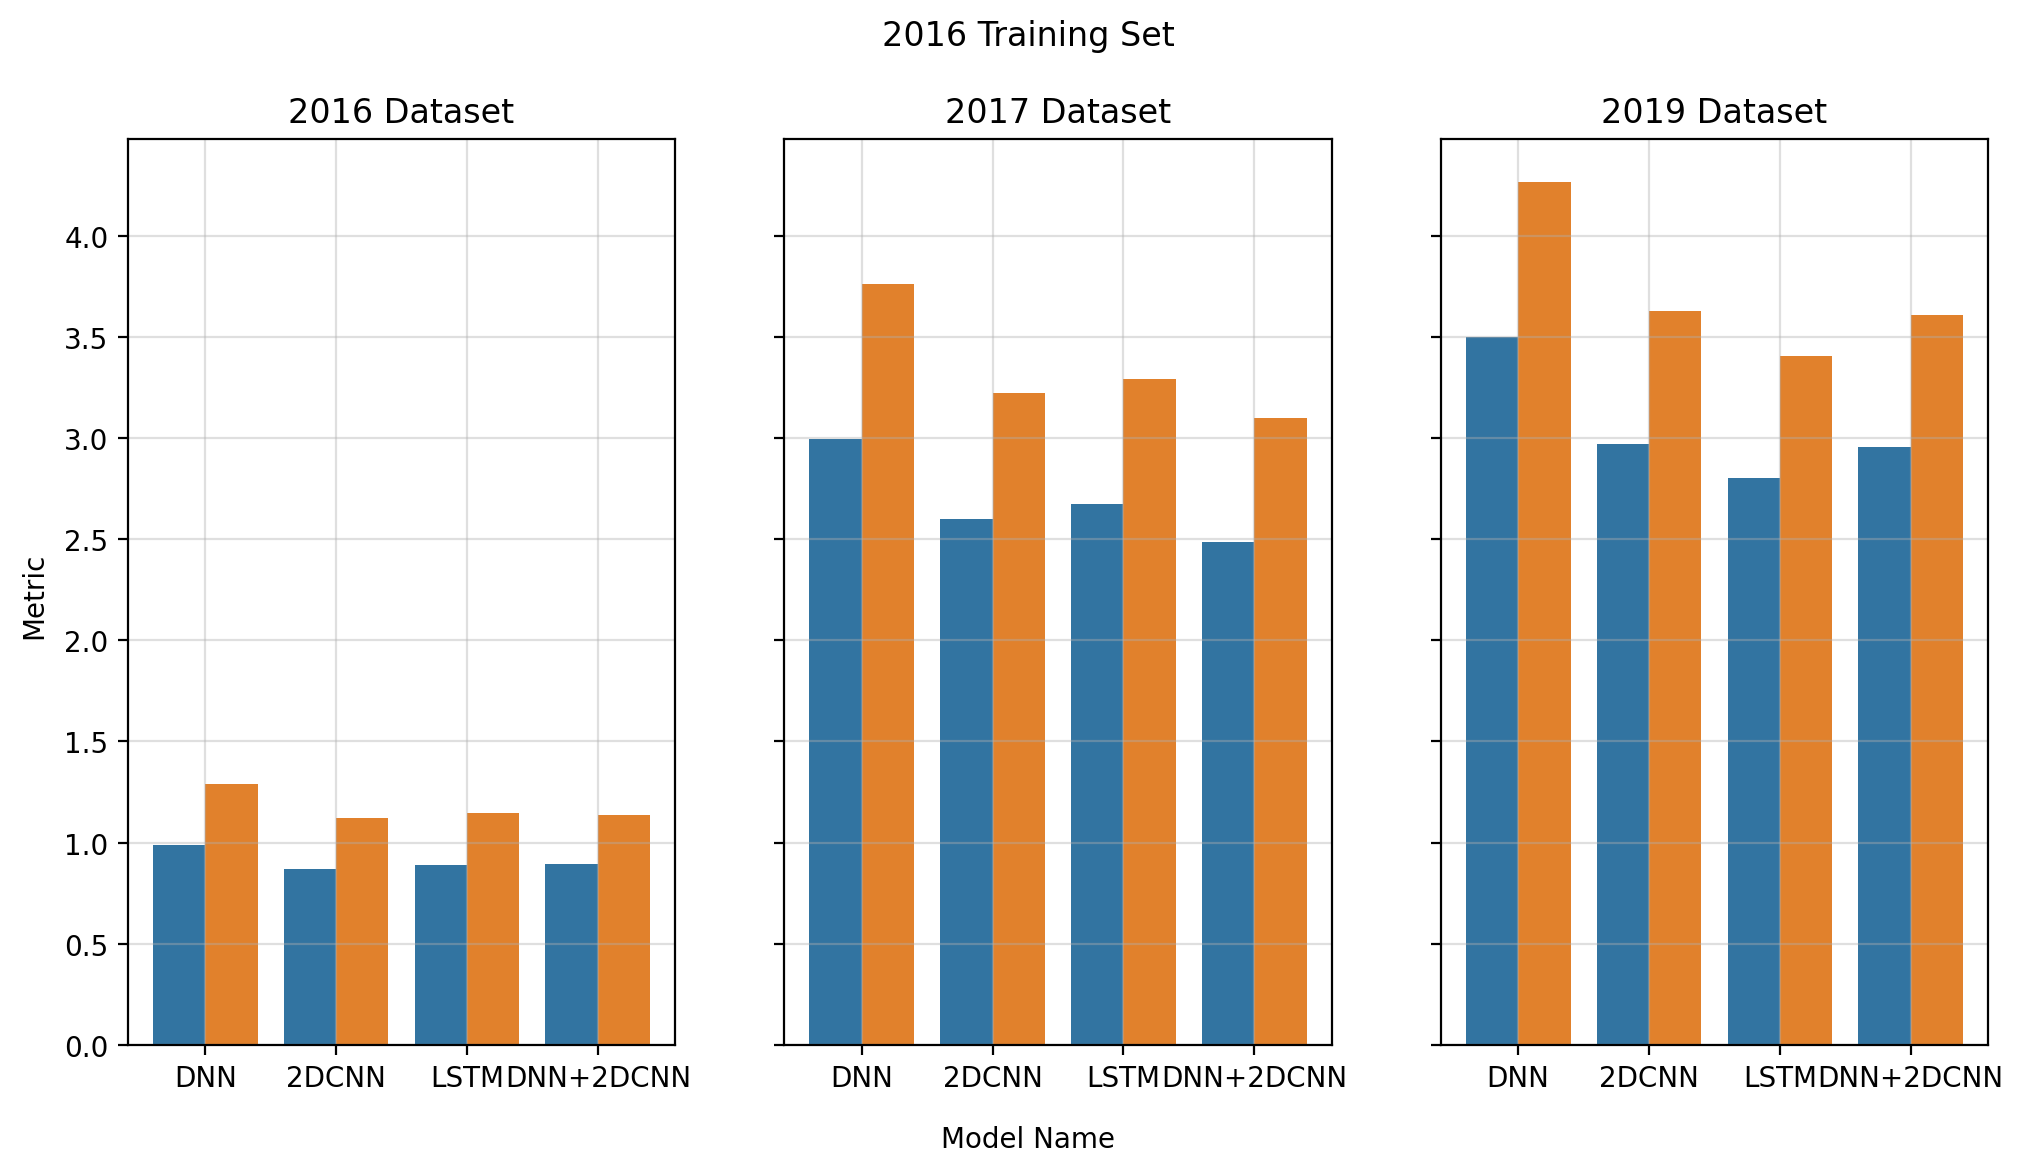

In [34]:
fig, ax = plt.subplots( ncols = 3, sharex = True, sharey = True ) 

names = [ '2016 Dataset', '2017 Dataset', '2019 Dataset' ]

for i, path in enumerate( paths ):
    plot = sns.barplot(
        ax = ax[i],
        data = pd.melt( transfer_results[transfer_results['Dataset'] == path], id_vars = 'Model Name', value_vars = [ 'Testing MAE', 'Testing RMSE' ] ),
        y = 'value',
        x = 'Model Name',
        hue = 'variable',
        palette = 'tab10'
    )
    plot.set_title( names[i] )
    ax[i].set_ylabel( '' )
    ax[i].set_xlabel( '' )
    ax[i].grid( alpha = 0.4 )
    ax[i].get_legend().remove()

fig.text( 0.5, 0.04, 'Model Name', ha='center')
fig.text( 0.08, 0.5, 'Metric', va='center', rotation='vertical')

plt.suptitle( '2016 Training Set' )
plt.plot()

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [71]:
predictions = models[0].predict( X_test )

18/18 [==============================] - 0s 4ms/step


In [72]:
predictions = np.round( predictions ).flatten()

In [73]:
predictions = np.round( predictions )

print( classification_report( y_test, predictions, labels = range( 14 ), target_names = [ key for key in grades.keys() ][1:] ) )

              precision    recall  f1-score   support

          6B       0.00      0.00      0.00         0
         6B+       0.75      0.58      0.66        77
          6C       0.37      0.48      0.42        65
         6C+       0.31      0.37      0.34        59
          7A       0.38      0.34      0.36        79
         7A+       0.35      0.27      0.31        82
          7B       0.33      0.35      0.34        60
         7B+       0.22      0.38      0.28        34
          7C       0.31      0.23      0.27        47
         7C+       0.17      0.12      0.14        26
          8A       0.25      0.23      0.24        13
         8A+       0.33      1.00      0.50         2
          8B       0.00      0.00      0.00         1
         8B+       0.00      0.00      0.00         0

   micro avg       0.37      0.37      0.37       545
   macro avg       0.27      0.31      0.27       545
weighted avg       0.38      0.37      0.37       545



/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/ho

Text(0.5, 1.0, 'Error vs Number of Holds')

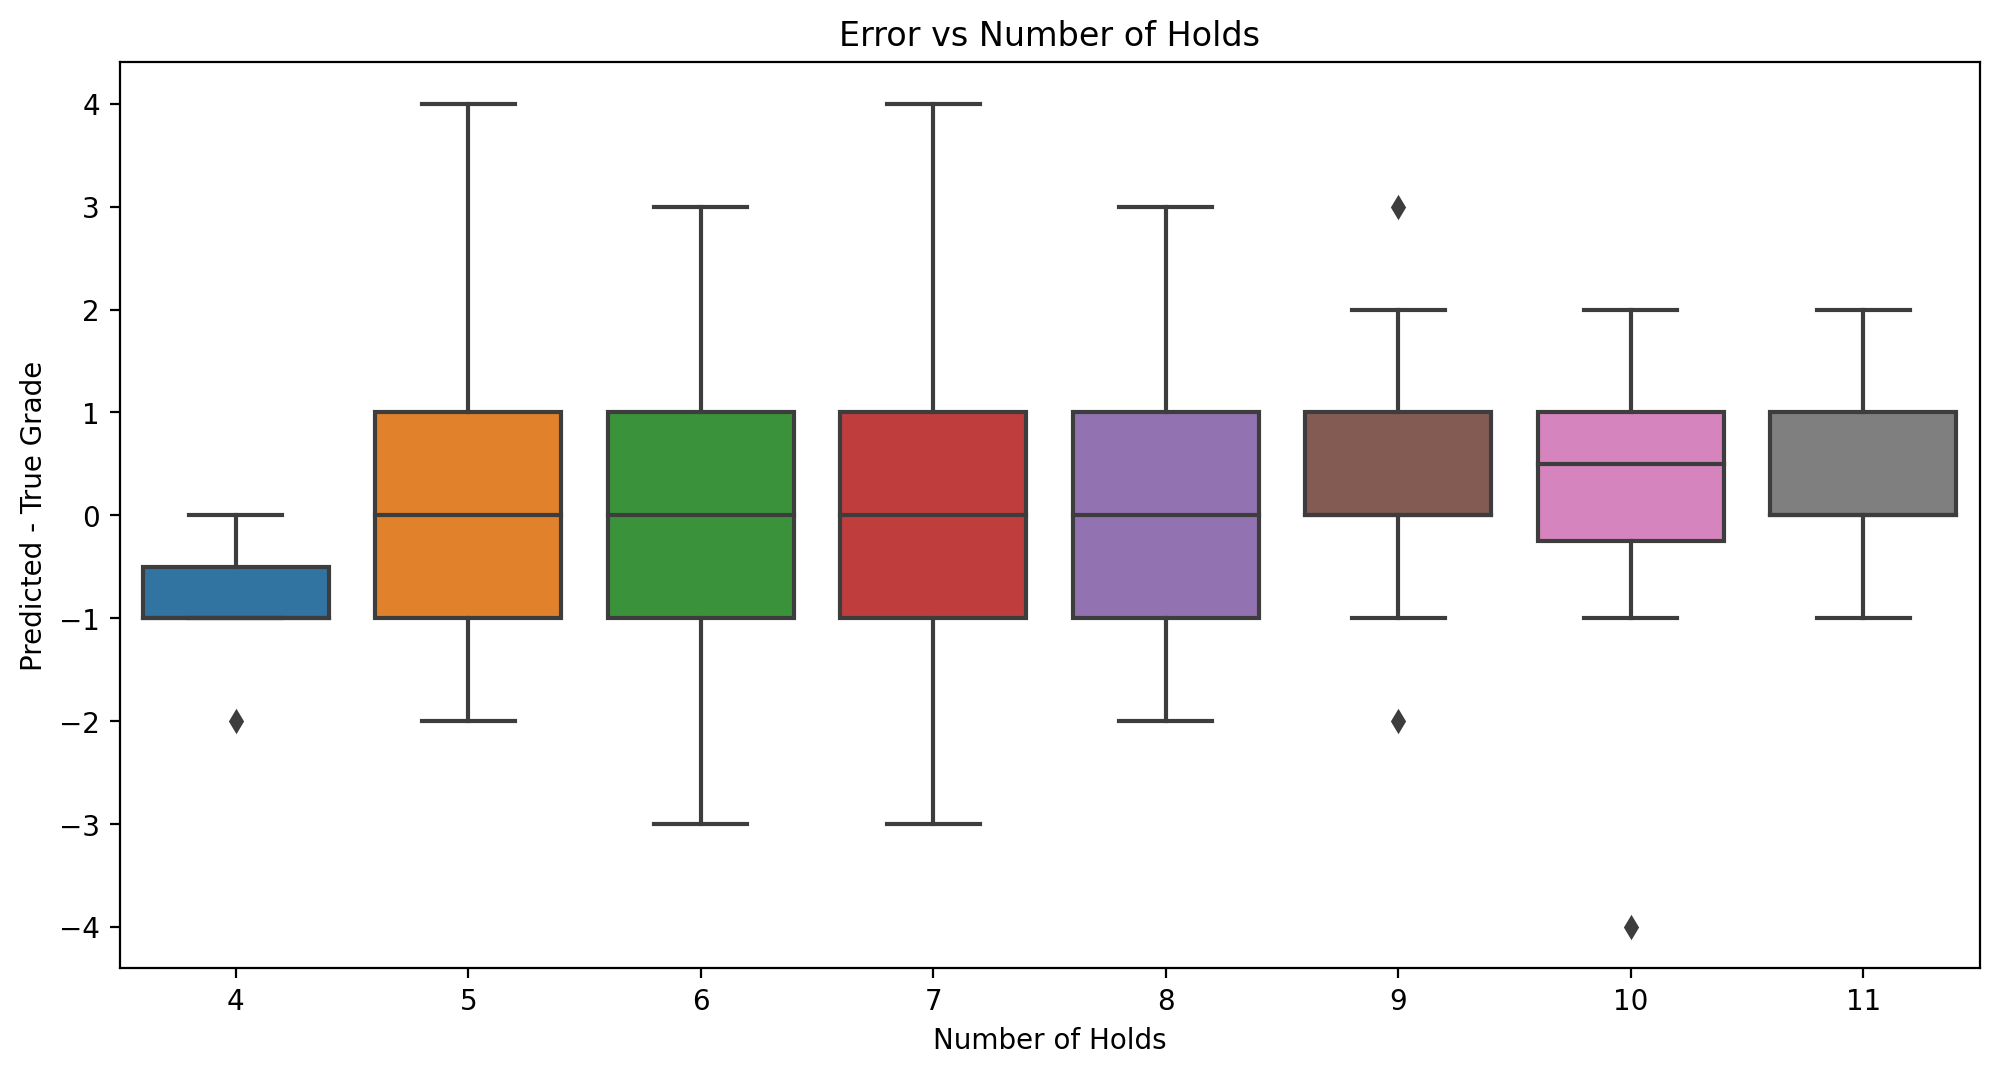

In [74]:
plot = sns.boxplot(
    np.sum( X_test > 0, axis = 1 ),
    ( predictions - y_test ),
)
plt.xlabel( 'Number of Holds' )
plt.ylabel( 'Predicted - True Grade' )
plt.title( 'Error vs Number of Holds' )

In [73]:
plot = sns.boxplot(
    np.sum( X_test > 0, axis = 1 ),
    np.abs( y_test - lr.predict( transform.transform( X_test ) ) ),
)
plt.xlabel( 'Number of Holds' )
plt.ylabel( 'Grade Error' )

NameError: name 'lr' is not defined

ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (15).

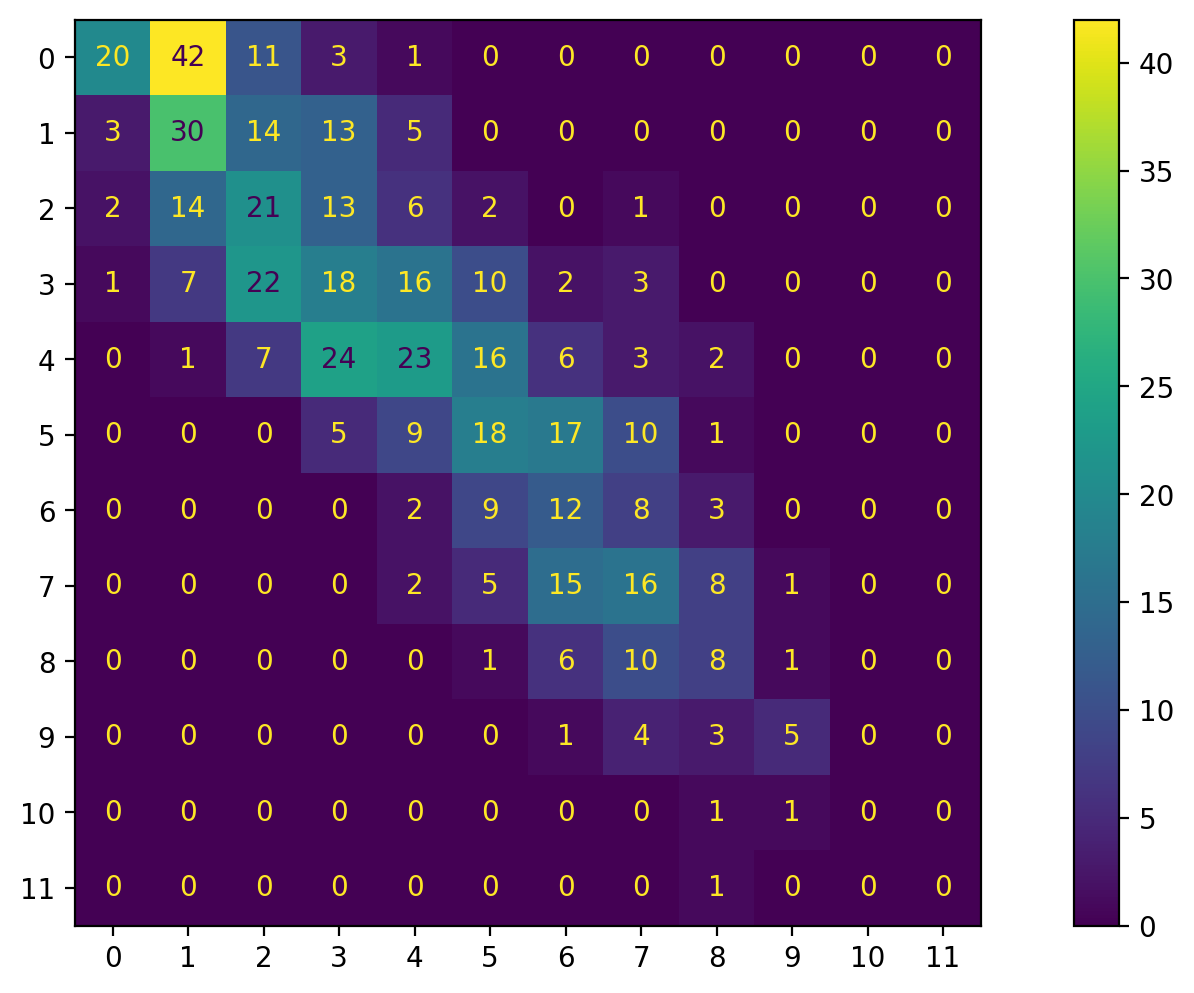

In [99]:
cm = confusion_matrix( y_test, predictions )
disp = ConfusionMatrixDisplay( confusion_matrix = cm, display_labels = grades )
disp.plot()
plt.show()

In [38]:
predictions = models[1].predict( X_test )

18/18 [==============================] - 0s 2ms/step


In [40]:
evaluate( [ 0 ], predictions, [ 0 ], y_test )

{'train_mae': 0.0,
 'train_rmse': 0.0,
 'test_mae': 0.8694568966506818,
 'test_rmse': 1.1223121061044932}

In [43]:
X_test.shape

(545, 198)

In [ ]:
np.abs( 

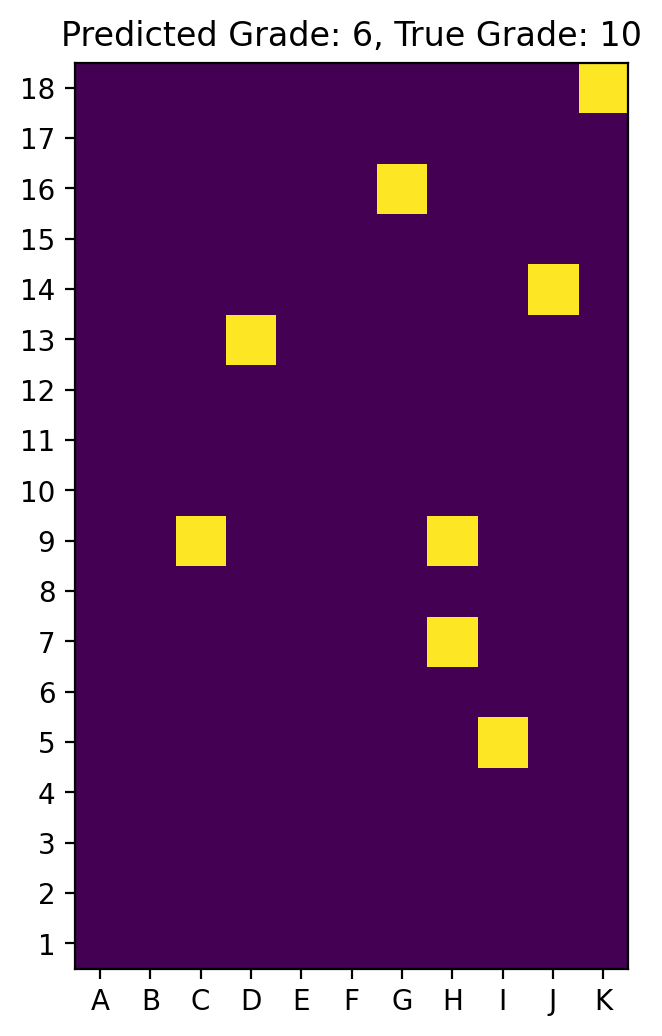

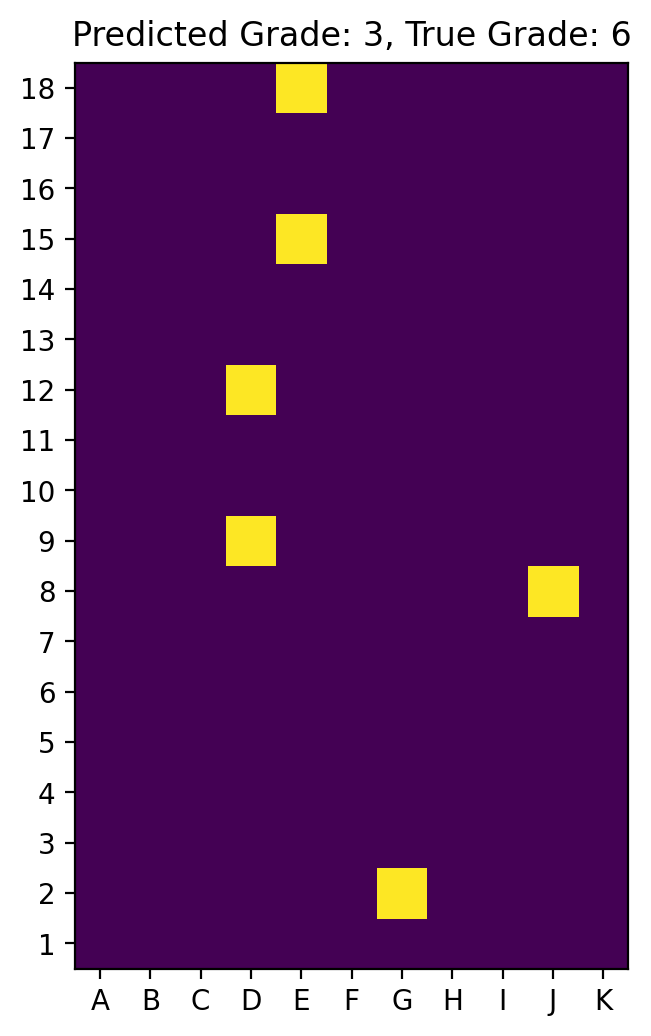

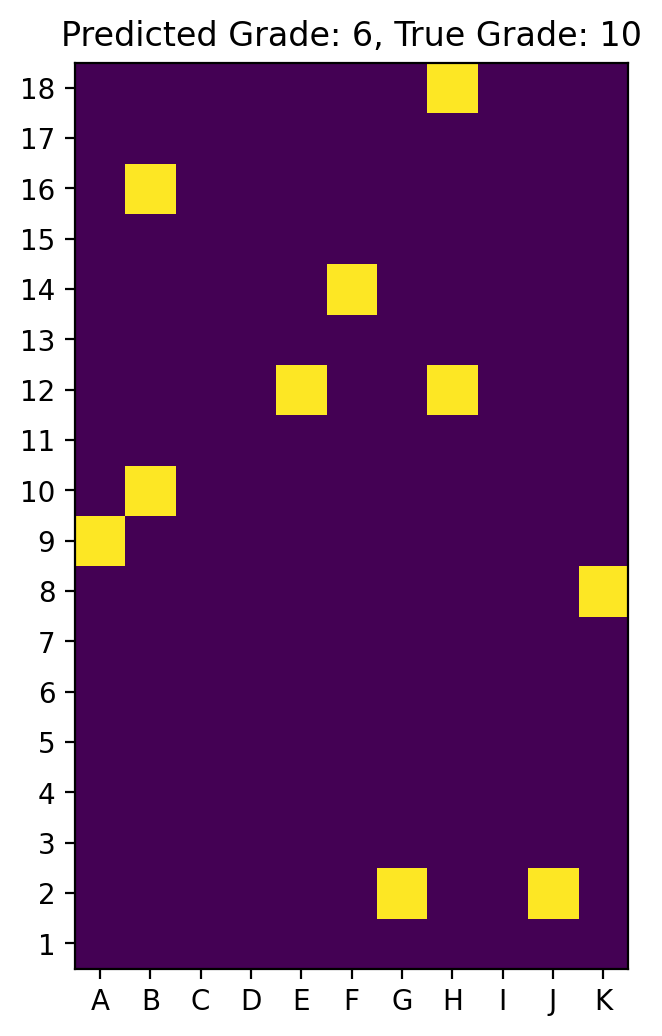

In [50]:
for x, y, pred in zip( X_test, y_test, predictions ):
    if abs( y - pred ) >= 3:
        plt.imshow( x.reshape( 18, 11 ) )
        plt.yticks( range( 18 ), range( 18, 0, -1 )  )
        plt.xticks( range( 11 ), [ c.upper() for c in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', ] ] )
        plt.title( f"Predicted Grade: {round( pred[0] )}, True Grade: {y}" )
        plt.show()

In [41]:
for climb in X_test[np.abs( y_test - predictions ) > 4]:
    plt.imshow( climb.reshape( 18, 11 ) )
    plt.yticks( range( 18 ), range( 18, 0, -1 )  )
    plt.xticks( range( 11 ), [ c.upper() for c in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', ] ] )
    plt.show()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 198 but corresponding boolean dimension is 545

In [100]:
# Add some engineered features:
# Number of holds
# Average distance between holds